In [1]:
%load_ext autoreload
%autoreload 2

import os
from jax import config
config.update("jax_enable_x64", True)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
from encoding_information.gpu_utils import limit_gpu_memory_growth
# limit_gpu_memory_growth()

from cleanplots import *
import jax.numpy as np
from jax.scipy.special import logsumexp
import numpy as onp
from encoding_information.image_utils import *
from encoding_information.information_estimation import *


2024-01-29 08:50:06.325608: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# load data
data_path = '/home/hpinkard_waller/data/DINO_debugging'
background = 50
photons_per_pixel = 400
patch_size = 39
sample = 'full_volume_lung'

single_lens_data = np.load(os.path.join(data_path, 'full_volume_lung_single_lens.npy'))
double_lens_data = np.load(os.path.join(data_path, 'full_volume_lung_double_lens.npy'))
many_lens_data = np.load(os.path.join(data_path, 'full_volume_lung_many_lens.npy'))

single_lens_data = single_lens_data / single_lens_data.mean() * photons_per_pixel
double_lens_data = double_lens_data / double_lens_data.mean() * photons_per_pixel
many_lens_data = many_lens_data / many_lens_data.mean() * photons_per_pixel

single_lens_data += background
double_lens_data += background
many_lens_data += background

data_min = min(single_lens_data.min(), double_lens_data.min(), many_lens_data.min())
data_max = max(single_lens_data.max(), double_lens_data.max(), many_lens_data.max())

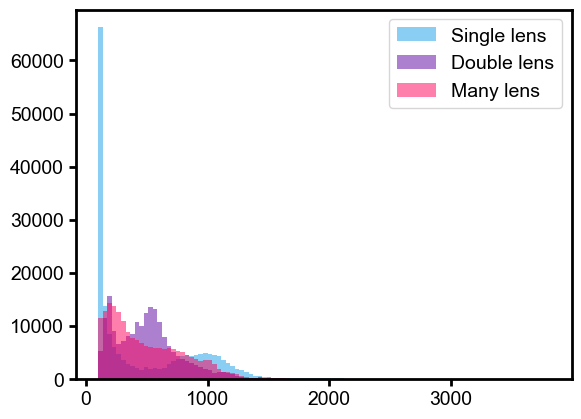

In [8]:
# plot histograms
fig, ax = plt.subplots()
hist_max = max(np.percentile(single_lens_data, 99.5), np.percentile(double_lens_data, 99.5), np.percentile(many_lens_data, 99.5))

bins = np.linspace(data_min, data_max, 100)
_ = ax.hist(single_lens_data[:8].ravel(), bins=bins, label='Single lens', alpha=0.5)
_ = ax.hist(double_lens_data[:8].ravel(), bins=bins, label='Double lens', alpha=0.5)
_ = ax.hist(many_lens_data[:8].ravel(), bins=bins, label='Many lens', alpha=0.5)
ax.legend()

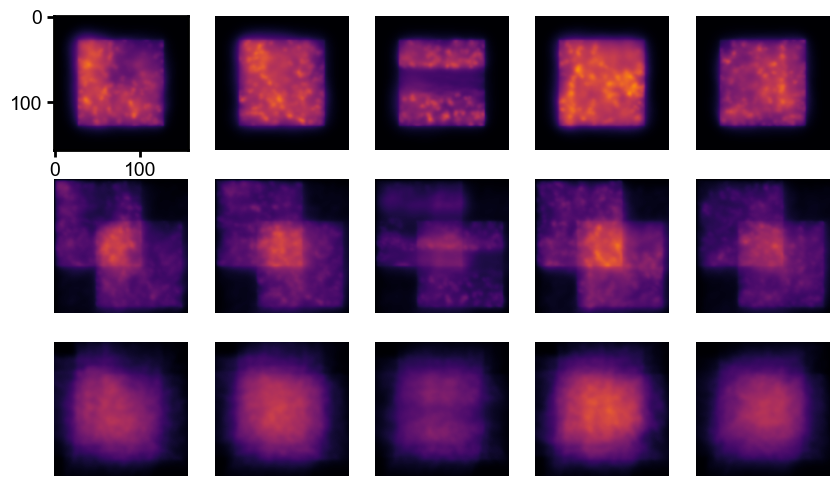

In [4]:
vmin = np.percentile(np.stack([single_lens_data, double_lens_data, many_lens_data]), 1)
vmax = np.percentile(np.stack([single_lens_data, double_lens_data, many_lens_data]), 99)


fig, axs = plt.subplots(3, 5, figsize=(10, 6))

for i in range(5):
    axs[0, i].imshow(single_lens_data[i], vmin=vmin, vmax=vmax, cmap='inferno')
    axs[1, i].imshow(double_lens_data[i], vmin=vmin, vmax=vmax, cmap='inferno')
    axs[2, i].imshow(many_lens_data[i], vmin=vmin, vmax=vmax, cmap='inferno')
    if i != 0:
        axs[0, i].axis('off')
    axs[1, i].axis('off')
    axs[2, i].axis('off')

100%|██████████| 6/6 [00:09<00:00,  1.54s/it]


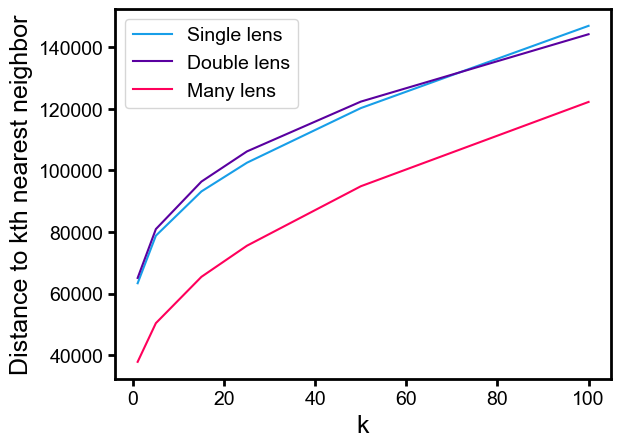

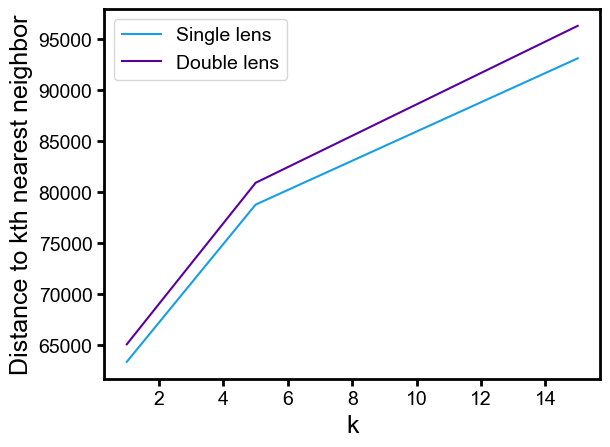

In [10]:
def extract_uniform_patches(data, patch_size, num_patches, verbose=False):
    """
    Extract patches from data with uniform random sampling
    """
    image_shape = data.shape[1:]
    if image_shape[0] % patch_size != 0 or image_shape[1] % patch_size != 0:
        raise ValueError('Patch size must evenly divide image size')
    num_blocks = image_shape[0] // patch_size
    blocks = []
    for i in range(num_blocks):
        for j in range(num_blocks):
            block = data[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            blocks.append(block)
    blocks = np.concatenate(blocks, axis=0)
    # take a random subset of them as patches
    indices = onp.random.choice(blocks.shape[0], num_patches, replace=False)
    return blocks[indices]

# Try nearest neighbor distance
from encoding_information.information_estimation import *

single_lens_patches = extract_uniform_patches(single_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
double_lens_patches = extract_uniform_patches(double_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
many_lens_patches = extract_uniform_patches(many_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)


@partial(jit, static_argnums=1)
def nearest_neighbors_distance(X, k):
    """
    Compute the distance to the kth nearest neighbor for each point in X by
    exhaustively searching all points in X.
    
    X : ndarray, shape (n_samples, W, H) or (n_samples, num_features)
    k : int
    """
    X = X.reshape(X.shape[0], -1)
    distance_matrix = np.sum((X[:, None, :] - X[None, :, :]) ** 2, axis=-1)
    kth_nn_index = np.argsort(distance_matrix, axis=-1)[:, k]
    kth_nn = X[kth_nn_index, :]
    kth_nn_dist = np.sum(np.abs(X - kth_nn), axis=-1)
    # kth_nn_dist = np.sqrt(np.sum((X - kth_nn)**2, axis=-1))
    return kth_nn_dist


single_lens_distances = []
double_lens_distances = []
many_lens_distances = []
ks = [1, 5, 15, 25, 50, 100]
for k in tqdm(ks):
    single_lens_distances.append(nearest_neighbors_distance(single_lens_patches, k).mean())
    double_lens_distances.append(nearest_neighbors_distance(double_lens_patches, k).mean())
    many_lens_distances.append(nearest_neighbors_distance(many_lens_patches, k).mean())

fig, ax = plt.subplots()
ax.plot(ks, single_lens_distances, label='Single lens')
ax.plot(ks, double_lens_distances, label='Double lens')
ax.plot(ks, many_lens_distances, label='Many lens')
ax.set_xlabel('k')
ax.set_ylabel('Distance to kth nearest neighbor')
ax.legend()

fig, ax = plt.subplots()
ax.plot(ks[:3], single_lens_distances[:3], label='Single lens')
ax.plot(ks[:3], double_lens_distances[:3], label='Double lens')
# ax.plot(ks, many_lens_distances[:3], label='Many lens')
ax.set_xlabel('k')
ax.set_ylabel('Distance to kth nearest neighbor')
ax.legend()

In [6]:
onp.array(single_lens_distances).shape

(6, 5000)

# Generate and train

100%|██████████| 10/10 [00:00<00:00, 204.37it/s]


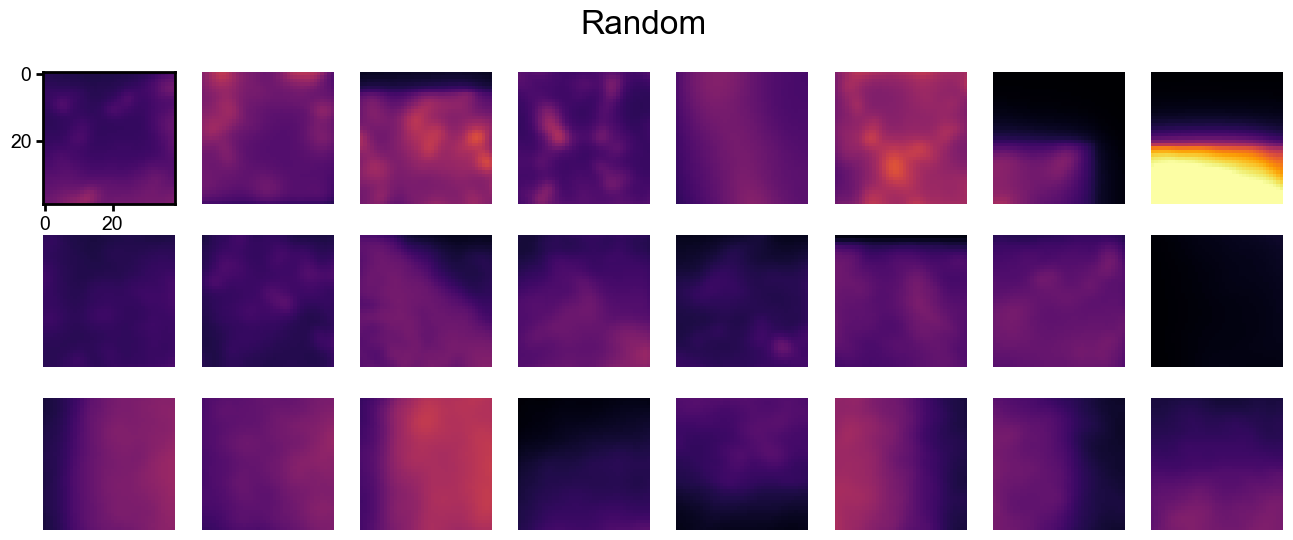

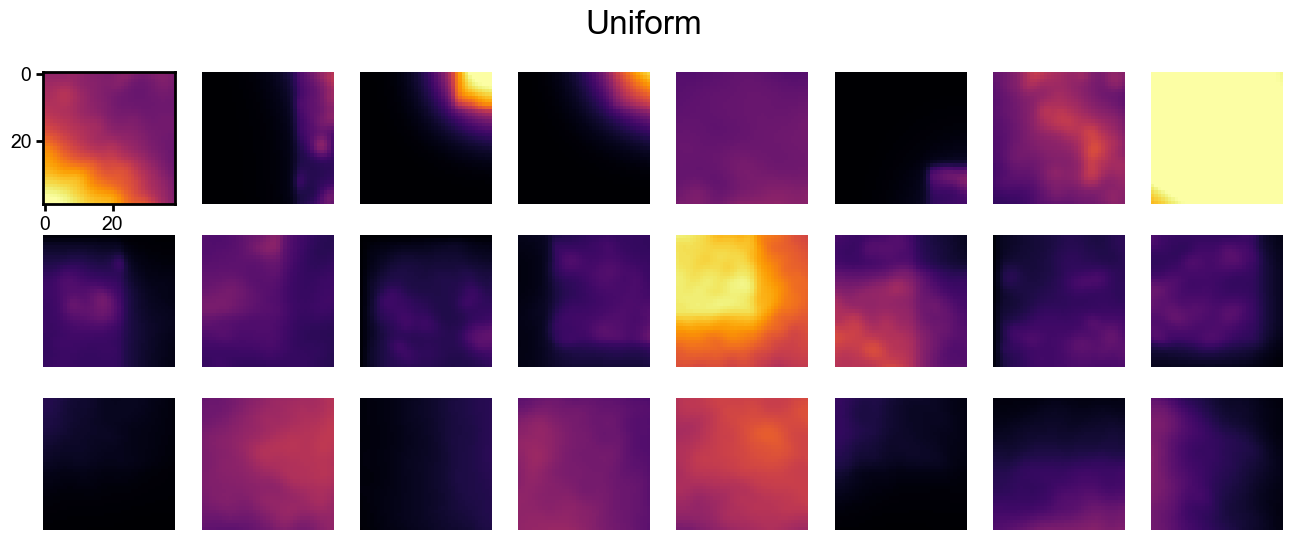

In [10]:
def extract_uniform_patches(data, patch_size, num_patches, verbose=False):
    """
    Extract patches from data with uniform random sampling
    """
    image_shape = data.shape[1:]
    if image_shape[0] % patch_size != 0 or image_shape[1] % patch_size != 0:
        raise ValueError('Patch size must evenly divide image size')
    num_blocks = image_shape[0] // patch_size
    blocks = []
    for i in range(num_blocks):
        for j in range(num_blocks):
            block = data[:, i*patch_size:(i+1)*patch_size, j*patch_size:(j+1)*patch_size]
            blocks.append(block)
    blocks = np.concatenate(blocks, axis=0)
    # take a random subset of them as patches
    indices = onp.random.choice(blocks.shape[0], num_patches, replace=False)
    return blocks[indices]


vmin = np.percentile(np.stack([single_lens_data, double_lens_data, many_lens_data]), 1)
vmax = np.percentile(np.stack([single_lens_data, double_lens_data, many_lens_data]), 99)


for uniform in [False, True]:

    if uniform:
        single_lens_patches = extract_uniform_patches(single_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
        double_lens_patches = extract_uniform_patches(double_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
        many_lens_patches = extract_uniform_patches(many_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
    else:
        single_lens_patches = extract_patches(single_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
        double_lens_patches = extract_patches(double_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
        many_lens_patches = extract_patches(many_lens_data, patch_size=patch_size, num_patches=10, verbose=True)
        

    fig, axs = plt.subplots(3, 8, figsize=(16, 6))

    for i in range(8):
        axs[0, i].imshow(single_lens_patches[i], vmin=vmin, vmax=vmax, cmap='inferno')
        axs[1, i].imshow(double_lens_patches[i], vmin=vmin, vmax=vmax, cmap='inferno')
        axs[2, i].imshow(many_lens_patches[i], vmin=vmin, vmax=vmax, cmap='inferno')
        if i != 0:
            axs[0, i].axis('off')
        axs[1, i].axis('off')
        axs[2, i].axis('off')
    fig.suptitle('Uniform' if uniform else 'Random')

In [11]:
for i in range(10):

    # single_lens_patches = extract_patches(single_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
    # double_lens_patches = extract_patches(double_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
    # many_lens_patches = extract_patches(many_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)

    single_lens_patches = extract_uniform_patches(single_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
    double_lens_patches = extract_uniform_patches(double_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)
    many_lens_patches = extract_uniform_patches(many_lens_data, patch_size=patch_size, num_patches=5000, verbose=True)

    single_lens_noisy_patches = add_noise(single_lens_patches)
    double_lens_noisy_patches = add_noise(double_lens_patches)
    many_lens_noisy_patches = add_noise(many_lens_patches)


    single_lens_mi_pcnn = estimate_mutual_information(single_lens_noisy_patches, clean_images=single_lens_patches, entropy_model='pixel_cnn', verbose=True)
    double_lens_mi_pcnn = estimate_mutual_information(double_lens_noisy_patches, clean_images=double_lens_patches, entropy_model='pixel_cnn', verbose=True)
    many_lens_mi_pcnn = estimate_mutual_information(many_lens_noisy_patches, clean_images=many_lens_patches, entropy_model='pixel_cnn', verbose=True)

    # do gaussian
    single_lens_mi_gaussian = estimate_mutual_information(single_lens_noisy_patches, clean_images=single_lens_patches, verbose=True)
    double_lens_mi_gaussian = estimate_mutual_information(double_lens_noisy_patches, clean_images=double_lens_patches,  verbose=True)
    many_lens_mi_gaussian = estimate_mutual_information(many_lens_noisy_patches, clean_images=many_lens_patches, verbose=True)


    def get_next_suffix(path):
        if not os.path.exists(path):
            return 0
        else:
            return len([f for f in os.listdir(path)])
        
    def save_data(data, gaussian_or_pcnn, lens):
        saving_path = [gaussian_or_pcnn, sample, lens, f'{photons_per_pixel}_photons', f'{background}_background']
        full_path = os.sep.join([data_path] + saving_path)
        # make this directory if it doesn't exist, creating intermediate directories as necessary
        os.makedirs(full_path, exist_ok=True)
        suffix = get_next_suffix(full_path)
        np.save(os.path.join(full_path, f'patch_{patch_size}_{suffix}.npy'), data)


    save_data(single_lens_mi_pcnn, 'pcnn', 'single_lens')
    save_data(double_lens_mi_pcnn, 'pcnn', 'double_lens')
    save_data(many_lens_mi_pcnn, 'pcnn', 'many_lens')

    save_data(single_lens_mi_gaussian, 'gaussian', 'single_lens')
    save_data(double_lens_mi_gaussian, 'gaussian', 'double_lens')
    save_data(many_lens_mi_gaussian, 'gaussian', 'many_lens')

2024-01-28 22:51:19.098009: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Initial validation NLL: 381.81


Epoch 1: 100%|██████████| 100/100 [00:27<00:00,  3.63it/s]


Epoch 1: validation NLL: 6.42


Epoch 2: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 2: validation NLL: 5.84


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 3: validation NLL: 7.45


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 4: validation NLL: 5.39


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 5: validation NLL: 5.54


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 6: validation NLL: 5.89


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 7: validation NLL: 5.88


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 8: validation NLL: 5.17


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 9: validation NLL: 6.21


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 10: validation NLL: 5.64


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 11: validation NLL: 6.10


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 12: validation NLL: 5.83


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 13: validation NLL: 6.08


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 14: validation NLL: 5.40


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 15: validation NLL: 5.58


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 16: validation NLL: 5.32


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 17: validation NLL: 4.92


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 18: validation NLL: 6.02


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 19: validation NLL: 5.68


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 20: validation NLL: 6.35


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 21: validation NLL: 8.62


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 22: validation NLL: 7.18


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 23: validation NLL: 7.17


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 24: validation NLL: 7.16


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 25: validation NLL: 7.16


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 26: validation NLL: 7.16


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 27: validation NLL: 7.16


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 28: validation NLL: 7.16


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 29: validation NLL: 7.16


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 30: validation NLL: 7.16


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 31: validation NLL: 7.16


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 32: validation NLL: 7.16


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 33: validation NLL: 7.16


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 34: validation NLL: 7.16


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 35: validation NLL: 7.16


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 36: validation NLL: 7.16


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 37: validation NLL: 7.16


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 38: validation NLL: 7.16


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 39: validation NLL: 7.16


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 40: validation NLL: 7.16


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 41: validation NLL: 7.15


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 42: validation NLL: 7.15


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 43: validation NLL: 7.15


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 44: validation NLL: 7.15


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 45: validation NLL: 7.15


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 46: validation NLL: 7.15


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 47: validation NLL: 7.15


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 48: validation NLL: 7.15


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 49: validation NLL: 7.15


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 50: validation NLL: 7.15


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Epoch 51: validation NLL: 7.15


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 52: validation NLL: 7.15


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 53: validation NLL: 7.15


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 54: validation NLL: 7.15


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 55: validation NLL: 7.15


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 56: validation NLL: 7.15


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 57: validation NLL: 7.15
Estimated H(Y|X) = 4.135 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.937 differential entropy/pixel
Estimated I(Y;X) = 1.156 bits/pixel
Initial validation NLL: 313.64


Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


Epoch 1: validation NLL: 6.15


Epoch 2: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 2: validation NLL: 5.45


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 3: validation NLL: 5.50


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 4: validation NLL: 4.66


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 5: validation NLL: 4.61


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 6: validation NLL: 5.34


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 7: validation NLL: 4.78


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 8: validation NLL: 4.91


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 9: validation NLL: 5.09


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 10: validation NLL: 4.60


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 11: validation NLL: 4.60


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 12: validation NLL: 4.60


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 13: validation NLL: 4.58


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 14: validation NLL: 4.97


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 15: validation NLL: 4.97


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


Epoch 16: validation NLL: 4.57


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 17: validation NLL: 4.56


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 18: validation NLL: 4.57


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 19: validation NLL: 4.69


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 20: validation NLL: 4.53


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 21: validation NLL: 4.55


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 22: validation NLL: 4.60


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 23: validation NLL: 4.67


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 24: validation NLL: 4.55


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 25: validation NLL: 4.65


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 26: validation NLL: 4.58


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 27: validation NLL: 5.13


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 28: validation NLL: 4.57


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 29: validation NLL: 4.84


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 30: validation NLL: 4.58


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 31: validation NLL: 4.75


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 32: validation NLL: 4.56


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 33: validation NLL: 4.51


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 34: validation NLL: 5.08


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 35: validation NLL: 4.87


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 36: validation NLL: 4.63


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 37: validation NLL: 4.58


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 38: validation NLL: 4.64


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 39: validation NLL: 4.56


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 40: validation NLL: 4.51


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 41: validation NLL: 4.51


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 42: validation NLL: 4.56


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 43: validation NLL: 4.60


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


Epoch 44: validation NLL: 4.51


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 45: validation NLL: 4.51


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 46: validation NLL: 4.50


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 47: validation NLL: 4.54


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Epoch 48: validation NLL: 4.64


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 49: validation NLL: 4.53


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 50: validation NLL: 4.50


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 51: validation NLL: 4.64


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 52: validation NLL: 4.50


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 53: validation NLL: 4.50


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 54: validation NLL: 4.67


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 55: validation NLL: 4.49


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 56: validation NLL: 4.56


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 57: validation NLL: 4.69


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 58: validation NLL: 4.53


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 59: validation NLL: 4.52


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 60: validation NLL: 4.59


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 61: validation NLL: 4.52


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 62: validation NLL: 4.52


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 63: validation NLL: 4.66


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 64: validation NLL: 4.50


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 65: validation NLL: 4.62


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 66: validation NLL: 4.49


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 67: validation NLL: 4.48


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 68: validation NLL: 4.50


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 69: validation NLL: 4.62


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 70: validation NLL: 4.51


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 71: validation NLL: 4.53


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 72: validation NLL: 4.49


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 73: validation NLL: 4.58


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 74: validation NLL: 4.49


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 75: validation NLL: 4.56


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 76: validation NLL: 4.49


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 77: validation NLL: 4.53


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  7.08it/s]


Epoch 78: validation NLL: 4.50


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 79: validation NLL: 4.48


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 80: validation NLL: 4.61


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 81: validation NLL: 4.52


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 82: validation NLL: 4.49


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 83: validation NLL: 4.51


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 84: validation NLL: 4.47


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 85: validation NLL: 4.51


Epoch 86: 100%|██████████| 100/100 [00:14<00:00,  7.11it/s]


Epoch 86: validation NLL: 4.57


Epoch 87: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 87: validation NLL: 4.48


Epoch 88: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 88: validation NLL: 4.51


Epoch 89: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 89: validation NLL: 4.48


Epoch 90: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 90: validation NLL: 4.58


Epoch 91: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 91: validation NLL: 4.48


Epoch 92: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 92: validation NLL: 4.50


Epoch 93: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 93: validation NLL: 16.35


Epoch 94: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 94: validation NLL: 4.99


Epoch 95: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 95: validation NLL: 4.76


Epoch 96: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 96: validation NLL: 4.62


Epoch 97: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 97: validation NLL: 4.59


Epoch 98: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 98: validation NLL: 4.57


Epoch 99: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 99: validation NLL: 4.60


Epoch 100: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 100: validation NLL: 4.72


Epoch 101: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 101: validation NLL: 4.56


Epoch 102: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 102: validation NLL: 4.54


Epoch 103: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Epoch 103: validation NLL: 4.56


Epoch 104: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 104: validation NLL: 4.54


Epoch 105: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 105: validation NLL: 4.54


Epoch 106: 100%|██████████| 100/100 [00:13<00:00,  7.29it/s]


Epoch 106: validation NLL: 4.81


Epoch 107: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 107: validation NLL: 4.53


Epoch 108: 100%|██████████| 100/100 [00:13<00:00,  7.18it/s]


Epoch 108: validation NLL: 4.67


Epoch 109: 100%|██████████| 100/100 [00:13<00:00,  7.29it/s]


Epoch 109: validation NLL: 4.54


Epoch 110: 100%|██████████| 100/100 [00:13<00:00,  7.33it/s]


Epoch 110: validation NLL: 4.54


Epoch 111: 100%|██████████| 100/100 [00:13<00:00,  7.20it/s]


Epoch 111: validation NLL: 4.53


Epoch 112: 100%|██████████| 100/100 [00:13<00:00,  7.22it/s]


Epoch 112: validation NLL: 4.53


Epoch 113: 100%|██████████| 100/100 [00:13<00:00,  7.27it/s]


Epoch 113: validation NLL: 4.54


Epoch 114: 100%|██████████| 100/100 [00:13<00:00,  7.21it/s]


Epoch 114: validation NLL: 4.58


Epoch 115: 100%|██████████| 100/100 [00:13<00:00,  7.27it/s]


Epoch 115: validation NLL: 4.55


Epoch 116: 100%|██████████| 100/100 [00:13<00:00,  7.35it/s]


Epoch 116: validation NLL: 4.53


Epoch 117: 100%|██████████| 100/100 [00:14<00:00,  7.14it/s]


Epoch 117: validation NLL: 4.60


Epoch 118: 100%|██████████| 100/100 [00:13<00:00,  7.26it/s]


Epoch 118: validation NLL: 4.60


Epoch 119: 100%|██████████| 100/100 [00:13<00:00,  7.30it/s]


Epoch 119: validation NLL: 4.53


Epoch 120: 100%|██████████| 100/100 [00:13<00:00,  7.35it/s]


Epoch 120: validation NLL: 4.52


Epoch 121: 100%|██████████| 100/100 [00:13<00:00,  7.36it/s]


Epoch 121: validation NLL: 4.52


Epoch 122: 100%|██████████| 100/100 [00:13<00:00,  7.32it/s]


Epoch 122: validation NLL: 4.54


Epoch 123: 100%|██████████| 100/100 [00:13<00:00,  7.15it/s]


Epoch 123: validation NLL: 4.53


Epoch 124: 100%|██████████| 100/100 [00:13<00:00,  7.18it/s]


Epoch 124: validation NLL: 4.51
Estimated H(Y|X) = 4.351 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.482 differential entropy/pixel
Estimated I(Y;X) = 0.190 bits/pixel
Initial validation NLL: 257.07


Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.79it/s]


Epoch 1: validation NLL: 5.48


Epoch 2: 100%|██████████| 100/100 [00:13<00:00,  7.17it/s]


Epoch 2: validation NLL: 5.17


Epoch 3: 100%|██████████| 100/100 [00:13<00:00,  7.19it/s]


Epoch 3: validation NLL: 5.04


Epoch 4: 100%|██████████| 100/100 [00:13<00:00,  7.17it/s]


Epoch 4: validation NLL: 4.98


Epoch 5: 100%|██████████| 100/100 [00:13<00:00,  7.15it/s]


Epoch 5: validation NLL: 4.62


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 6: validation NLL: 4.76


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Epoch 7: validation NLL: 4.51


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  7.12it/s]


Epoch 8: validation NLL: 4.53


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Epoch 9: validation NLL: 4.47


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 10: validation NLL: 4.45


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 11: validation NLL: 4.51


Epoch 12: 100%|██████████| 100/100 [00:13<00:00,  7.20it/s]


Epoch 12: validation NLL: 5.05


Epoch 13: 100%|██████████| 100/100 [00:13<00:00,  7.17it/s]


Epoch 13: validation NLL: 4.72


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 14: validation NLL: 4.50


Epoch 15: 100%|██████████| 100/100 [00:13<00:00,  7.25it/s]


Epoch 15: validation NLL: 4.62


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  7.11it/s]


Epoch 16: validation NLL: 4.49


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 17: validation NLL: 4.60


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  7.08it/s]


Epoch 18: validation NLL: 4.64


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  7.08it/s]


Epoch 19: validation NLL: 4.56


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 20: validation NLL: 4.46


Epoch 21: 100%|██████████| 100/100 [00:13<00:00,  7.24it/s]


Epoch 21: validation NLL: 4.43


Epoch 22: 100%|██████████| 100/100 [00:13<00:00,  7.30it/s]


Epoch 22: validation NLL: 4.54


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 23: validation NLL: 4.78


Epoch 24: 100%|██████████| 100/100 [00:13<00:00,  7.35it/s]


Epoch 24: validation NLL: 5.64


Epoch 25: 100%|██████████| 100/100 [00:13<00:00,  7.33it/s]


Epoch 25: validation NLL: 4.79


Epoch 26: 100%|██████████| 100/100 [00:13<00:00,  7.19it/s]


Epoch 26: validation NLL: 4.51


Epoch 27: 100%|██████████| 100/100 [00:13<00:00,  7.27it/s]


Epoch 27: validation NLL: 4.47


Epoch 28: 100%|██████████| 100/100 [00:13<00:00,  7.30it/s]


Epoch 28: validation NLL: 4.44


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  7.09it/s]


Epoch 29: validation NLL: 4.48


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 30: validation NLL: 4.53


Epoch 31: 100%|██████████| 100/100 [00:13<00:00,  7.17it/s]


Epoch 31: validation NLL: 4.42


Epoch 32: 100%|██████████| 100/100 [00:13<00:00,  7.23it/s]


Epoch 32: validation NLL: 4.44


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


Epoch 33: validation NLL: 4.41


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 34: validation NLL: 4.43


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  7.08it/s]


Epoch 35: validation NLL: 4.45


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 36: validation NLL: 4.44


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  7.14it/s]


Epoch 37: validation NLL: 4.41


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 38: validation NLL: 4.44


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 39: validation NLL: 4.41


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 40: validation NLL: 4.45


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 41: validation NLL: 4.42


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  7.11it/s]


Epoch 42: validation NLL: 4.44


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 43: validation NLL: 4.55


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Epoch 44: validation NLL: 4.53


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Epoch 45: validation NLL: 4.41


Epoch 46: 100%|██████████| 100/100 [00:13<00:00,  7.28it/s]


Epoch 46: validation NLL: 4.41


Epoch 47: 100%|██████████| 100/100 [00:13<00:00,  7.29it/s]


Epoch 47: validation NLL: 4.40


Epoch 48: 100%|██████████| 100/100 [00:13<00:00,  7.31it/s]


Epoch 48: validation NLL: 4.40


Epoch 49: 100%|██████████| 100/100 [00:13<00:00,  7.31it/s]


Epoch 49: validation NLL: 4.59


Epoch 50: 100%|██████████| 100/100 [00:13<00:00,  7.28it/s]


Epoch 50: validation NLL: 4.53


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  7.09it/s]


Epoch 51: validation NLL: 4.67


Epoch 52: 100%|██████████| 100/100 [00:13<00:00,  7.28it/s]


Epoch 52: validation NLL: 4.45


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  7.11it/s]


Epoch 53: validation NLL: 4.39


Epoch 54: 100%|██████████| 100/100 [00:13<00:00,  7.34it/s]


Epoch 54: validation NLL: 4.70


Epoch 55: 100%|██████████| 100/100 [00:13<00:00,  7.28it/s]


Epoch 55: validation NLL: 4.41


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 56: validation NLL: 4.44


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  7.14it/s]


Epoch 57: validation NLL: 4.39


Epoch 58: 100%|██████████| 100/100 [00:13<00:00,  7.34it/s]


Epoch 58: validation NLL: 4.38


Epoch 59: 100%|██████████| 100/100 [00:13<00:00,  7.30it/s]


Epoch 59: validation NLL: 4.91


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 60: validation NLL: 6.81


Epoch 61: 100%|██████████| 100/100 [00:13<00:00,  7.34it/s]


Epoch 61: validation NLL: 6.69


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  7.14it/s]


Epoch 62: validation NLL: 6.69


Epoch 63: 100%|██████████| 100/100 [00:13<00:00,  7.23it/s]


Epoch 63: validation NLL: 6.69


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 64: validation NLL: 6.69


Epoch 65: 100%|██████████| 100/100 [00:13<00:00,  7.16it/s]


Epoch 65: validation NLL: 6.69


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 66: validation NLL: 6.69


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 67: validation NLL: 6.69


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 68: validation NLL: 6.69


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Epoch 69: validation NLL: 6.69


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  7.13it/s]


Epoch 70: validation NLL: 6.69


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 71: validation NLL: 6.69


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 72: validation NLL: 6.69


Epoch 73: 100%|██████████| 100/100 [00:13<00:00,  7.35it/s]


Epoch 73: validation NLL: 6.69


Epoch 74: 100%|██████████| 100/100 [00:13<00:00,  7.22it/s]


Epoch 74: validation NLL: 6.69


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  7.14it/s]


Epoch 75: validation NLL: 6.69


Epoch 76: 100%|██████████| 100/100 [00:13<00:00,  7.23it/s]


Epoch 76: validation NLL: 6.69


Epoch 77: 100%|██████████| 100/100 [00:13<00:00,  7.34it/s]


Epoch 77: validation NLL: 6.69


Epoch 78: 100%|██████████| 100/100 [00:13<00:00,  7.33it/s]


Epoch 78: validation NLL: 6.69


Epoch 79: 100%|██████████| 100/100 [00:13<00:00,  7.26it/s]


Epoch 79: validation NLL: 6.69


Epoch 80: 100%|██████████| 100/100 [00:13<00:00,  7.15it/s]


Epoch 80: validation NLL: 6.69


Epoch 81: 100%|██████████| 100/100 [00:13<00:00,  7.35it/s]


Epoch 81: validation NLL: 6.69


Epoch 82: 100%|██████████| 100/100 [00:13<00:00,  7.22it/s]


Epoch 82: validation NLL: 6.69


Epoch 83: 100%|██████████| 100/100 [00:13<00:00,  7.33it/s]


Epoch 83: validation NLL: 6.69


Epoch 84: 100%|██████████| 100/100 [00:13<00:00,  7.31it/s]


Epoch 84: validation NLL: 6.69


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  7.13it/s]


Epoch 85: validation NLL: 6.69


Epoch 86: 100%|██████████| 100/100 [00:13<00:00,  7.16it/s]


Epoch 86: validation NLL: 6.69


Epoch 87: 100%|██████████| 100/100 [00:13<00:00,  7.27it/s]


Epoch 87: validation NLL: 6.69


Epoch 88: 100%|██████████| 100/100 [00:13<00:00,  7.36it/s]


Epoch 88: validation NLL: 6.69


Epoch 89: 100%|██████████| 100/100 [00:13<00:00,  7.30it/s]


Epoch 89: validation NLL: 6.69


Epoch 90: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 90: validation NLL: 6.69


Epoch 91: 100%|██████████| 100/100 [00:13<00:00,  7.28it/s]


Epoch 91: validation NLL: 6.69


Epoch 92: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 92: validation NLL: 6.69


Epoch 93: 100%|██████████| 100/100 [00:14<00:00,  7.13it/s]


Epoch 93: validation NLL: 6.69


Epoch 94: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 94: validation NLL: 6.69


Epoch 95: 100%|██████████| 100/100 [00:13<00:00,  7.15it/s]


Epoch 95: validation NLL: 6.69


Epoch 96: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 96: validation NLL: 6.69


Epoch 97: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 97: validation NLL: 6.69


Epoch 98: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 98: validation NLL: 6.69
Estimated H(Y|X) = 4.298 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.441 differential entropy/pixel
Estimated I(Y;X) = 0.207 bits/pixel


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 0.001
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +
/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 0.01
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +
/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive

trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
Initial validation NLL: 15.55


Epoch 1: 100%|██████████| 1/1 [00:40<00:00, 40.76s/it]
/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/image_distribution_models.py:237: UserWarning: NaN encountered in validation loss. Stopping early.
  warnings.warn('NaN encountered in validation loss. Stopping early.')
precomputing masks and variances: 100%|██████████| 39/39 [00:00<00:00, 51.68it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 39/39 [00:00<00:00, 95.59it/s]


Estimated H(Y|X) = 4.135 differential entropy/pixel
Estimated H(Y) (Upper bound) = 16.247 differential entropy/pixel
Estimated I(Y;X) = 17.474 bits/pixel
trying eigenvalue floor of 0.01


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 0.001
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +
/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 0.01
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +
/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive

trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0


/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:43: UserWarning: Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.Try raising the eigenvalue floor than the current value of 10.0
  warnings.warn('Covariance matrix is not positive definite even after applying eigenvalue floor. This indicates numerical error.' +


Initial validation NLL: 8.01


Epoch 1: 100%|██████████| 1/1 [00:22<00:00, 22.92s/it]
/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/image_distribution_models.py:237: UserWarning: NaN encountered in validation loss. Stopping early.
  warnings.warn('NaN encountered in validation loss. Stopping early.')
precomputing masks and variances: 100%|██████████| 39/39 [00:00<00:00, 85.94it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 39/39 [00:00<00:00, 75.80it/s]


Estimated H(Y|X) = 4.351 differential entropy/pixel
Estimated H(Y) (Upper bound) = 8.473 differential entropy/pixel
Estimated I(Y;X) = 5.948 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 4.86


precomputing masks and variances: 100%|██████████| 39/39 [00:00<00:00, 70.08it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 39/39 [00:00<00:00, 88.14it/s]


Estimated H(Y|X) = 4.298 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.954 differential entropy/pixel
Estimated I(Y;X) = 0.947 bits/pixel
Initial validation NLL: 341.49


Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.46it/s]


Epoch 1: validation NLL: 6.25


Epoch 2: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 2: validation NLL: 5.96


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 3: validation NLL: 4.99


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 4: validation NLL: 5.61


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 5: validation NLL: 5.78


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 6: validation NLL: 5.99


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 7: validation NLL: 5.08


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 8: validation NLL: 7.57


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 9: validation NLL: 6.64


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 10: validation NLL: 7.18


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 11: validation NLL: 7.16


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 12: validation NLL: 7.15


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 13: validation NLL: 7.15


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 14: validation NLL: 7.15


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 15: validation NLL: 7.15


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 16: validation NLL: 7.15


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 17: validation NLL: 7.15


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 18: validation NLL: 7.15


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 19: validation NLL: 7.15


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 20: validation NLL: 7.15


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 21: validation NLL: 7.15


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 22: validation NLL: 7.15


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 23: validation NLL: 7.15


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 24: validation NLL: 7.15


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 25: validation NLL: 7.15


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 26: validation NLL: 7.15


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 27: validation NLL: 7.15


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 28: validation NLL: 7.15


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 29: validation NLL: 7.15


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 30: validation NLL: 7.15


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 31: validation NLL: 7.15


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 32: validation NLL: 7.15


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 33: validation NLL: 7.15


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 34: validation NLL: 7.15


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 35: validation NLL: 7.15


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 36: validation NLL: 7.15


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Epoch 37: validation NLL: 7.15


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 38: validation NLL: 7.15


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 39: validation NLL: 7.15


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 40: validation NLL: 7.15


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 41: validation NLL: 7.15


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 42: validation NLL: 7.15


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 43: validation NLL: 7.15
Estimated H(Y|X) = 4.139 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.984 differential entropy/pixel
Estimated I(Y;X) = 1.219 bits/pixel
Initial validation NLL: 292.55


Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


Epoch 1: validation NLL: 5.67


Epoch 2: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 2: validation NLL: 5.29


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 3: validation NLL: 5.25


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 4: validation NLL: 5.18


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 5: validation NLL: 4.95


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 6: validation NLL: 5.78


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 7: validation NLL: 4.89


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 8: validation NLL: 4.69


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 9: validation NLL: 4.97


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 10: validation NLL: 4.65


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 11: validation NLL: 4.67


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 12: validation NLL: 5.29


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 13: validation NLL: 5.26


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 14: validation NLL: 4.57


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 15: validation NLL: 4.72


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 16: validation NLL: 4.52


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 17: validation NLL: 4.56


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 18: validation NLL: 4.57


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 19: validation NLL: 4.83


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 20: validation NLL: 4.54


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 21: validation NLL: 4.54


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 22: validation NLL: 4.69


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 23: validation NLL: 5.00


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 24: validation NLL: 4.72


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 25: validation NLL: 4.60


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 26: validation NLL: 5.19


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 27: validation NLL: 4.54


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 28: validation NLL: 4.68


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 29: validation NLL: 4.55


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 30: validation NLL: 4.53


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 31: validation NLL: 4.71


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 32: validation NLL: 4.59


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 33: validation NLL: 4.58


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 34: validation NLL: 4.53


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 35: validation NLL: 4.60


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 36: validation NLL: 4.52


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 37: validation NLL: 4.50


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 38: validation NLL: 4.64


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 39: validation NLL: 4.49


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 40: validation NLL: 4.82


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 41: validation NLL: 4.94


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 42: validation NLL: 4.73


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 43: validation NLL: 4.81


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 44: validation NLL: 4.59


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 45: validation NLL: 4.59


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 46: validation NLL: 4.52


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 47: validation NLL: 4.52


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 48: validation NLL: 4.53


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 49: validation NLL: 4.57


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 50: validation NLL: 4.75


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 51: validation NLL: 4.52


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 52: validation NLL: 4.52


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 53: validation NLL: 4.56


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 54: validation NLL: 4.57


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 55: validation NLL: 4.51


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 56: validation NLL: 4.55


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 57: validation NLL: 4.51


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 58: validation NLL: 4.56


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 59: validation NLL: 4.51


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 60: validation NLL: 4.60


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 61: validation NLL: 4.60


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 62: validation NLL: 4.52


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 63: validation NLL: 4.49


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 64: validation NLL: 4.51


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 65: validation NLL: 4.50


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 66: validation NLL: 4.62


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 67: validation NLL: 4.49


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 68: validation NLL: 4.69


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 69: validation NLL: 4.50


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 70: validation NLL: 4.61


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 71: validation NLL: 4.49


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 72: validation NLL: 4.48


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 73: validation NLL: 4.49


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 74: validation NLL: 4.49


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 75: validation NLL: 4.49


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 76: validation NLL: 4.53


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 77: validation NLL: 4.52


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 78: validation NLL: 4.51


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 79: validation NLL: 4.53


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 80: validation NLL: 4.52


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 81: validation NLL: 4.55


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 82: validation NLL: 4.48


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 83: validation NLL: 4.51


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 84: validation NLL: 4.48


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 85: validation NLL: 4.51


Epoch 86: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 86: validation NLL: 4.48


Epoch 87: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 87: validation NLL: 4.50


Epoch 88: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 88: validation NLL: 4.50


Epoch 89: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 89: validation NLL: 4.50


Epoch 90: 100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Epoch 90: validation NLL: 4.50


Epoch 91: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 91: validation NLL: 4.48


Epoch 92: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 92: validation NLL: 4.49


Epoch 93: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 93: validation NLL: 4.53


Epoch 94: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 94: validation NLL: 4.50


Epoch 95: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 95: validation NLL: 4.50


Epoch 96: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 96: validation NLL: 4.50


Epoch 97: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 97: validation NLL: 4.48


Epoch 98: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 98: validation NLL: 4.48


Epoch 99: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 99: validation NLL: 4.54


Epoch 100: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 100: validation NLL: 4.49


Epoch 101: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 101: validation NLL: 4.49


Epoch 102: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 102: validation NLL: 4.49


Epoch 103: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 103: validation NLL: 4.56


Epoch 104: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 104: validation NLL: 4.48


Epoch 105: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 105: validation NLL: 4.51


Epoch 106: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 106: validation NLL: 4.57


Epoch 107: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 107: validation NLL: 5.99


Epoch 108: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 108: validation NLL: 4.81


Epoch 109: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 109: validation NLL: 4.65


Epoch 110: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 110: validation NLL: 4.76


Epoch 111: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 111: validation NLL: 4.62


Epoch 112: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 112: validation NLL: 4.57


Epoch 113: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 113: validation NLL: 4.55


Epoch 114: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 114: validation NLL: 4.55


Epoch 115: 100%|██████████| 100/100 [00:14<00:00,  7.12it/s]


Epoch 115: validation NLL: 4.54


Epoch 116: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 116: validation NLL: 4.61


Epoch 117: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 117: validation NLL: 4.63


Epoch 118: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 118: validation NLL: 4.53


Epoch 119: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 119: validation NLL: 4.56


Epoch 120: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 120: validation NLL: 4.52


Epoch 121: 100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


Epoch 121: validation NLL: 4.54


Epoch 122: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 122: validation NLL: 4.54


Epoch 123: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 123: validation NLL: 4.62


Epoch 124: 100%|██████████| 100/100 [00:14<00:00,  7.12it/s]


Epoch 124: validation NLL: 4.54


Epoch 125: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 125: validation NLL: 4.54


Epoch 126: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 126: validation NLL: 4.51


Epoch 127: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 127: validation NLL: 4.52


Epoch 128: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 128: validation NLL: 4.51


Epoch 129: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 129: validation NLL: 4.50


Epoch 130: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 130: validation NLL: 4.52


Epoch 131: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 131: validation NLL: 4.50


Epoch 132: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 132: validation NLL: 4.50


Epoch 133: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 133: validation NLL: 4.49


Epoch 134: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 134: validation NLL: 4.49


Epoch 135: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 135: validation NLL: 4.51


Epoch 136: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 136: validation NLL: 4.49


Epoch 137: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 137: validation NLL: 4.52


Epoch 138: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 138: validation NLL: 4.51


Epoch 139: 100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


Epoch 139: validation NLL: 4.49


Epoch 140: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 140: validation NLL: 4.65


Epoch 141: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 141: validation NLL: 4.52


Epoch 142: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 142: validation NLL: 4.53


Epoch 143: 100%|██████████| 100/100 [00:14<00:00,  7.08it/s]


Epoch 143: validation NLL: 4.50


Epoch 144: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 144: validation NLL: 4.49
Estimated H(Y|X) = 4.345 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.467 differential entropy/pixel
Estimated I(Y;X) = 0.177 bits/pixel
Initial validation NLL: 308.28


Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.66it/s]


Epoch 1: validation NLL: 6.03


Epoch 2: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 2: validation NLL: 5.39


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 3: validation NLL: 5.10


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 4: validation NLL: 5.06


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 5: validation NLL: 5.17


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 6: validation NLL: 4.91


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


Epoch 7: validation NLL: 4.70


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 8: validation NLL: 4.59


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 9: validation NLL: 4.55


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 10: validation NLL: 4.63


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 11: validation NLL: 5.00


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 12: validation NLL: 4.61


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 13: validation NLL: 4.59


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 14: validation NLL: 4.51


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 15: validation NLL: 4.59


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 16: validation NLL: 4.51


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 17: validation NLL: 4.48


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 18: validation NLL: 4.48


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 19: validation NLL: 4.70


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 20: validation NLL: 4.54


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 21: validation NLL: 4.52


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 22: validation NLL: 4.49


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 23: validation NLL: 4.55


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 24: validation NLL: 4.56


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 25: validation NLL: 4.47


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 26: validation NLL: 4.58


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 27: validation NLL: 4.51


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 28: validation NLL: 4.52


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 29: validation NLL: 4.49


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 30: validation NLL: 4.52


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 31: validation NLL: 4.45


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 32: validation NLL: 4.48


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 33: validation NLL: 4.50


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 34: validation NLL: 4.50


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 35: validation NLL: 4.46


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 36: validation NLL: 4.51


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 37: validation NLL: 4.44


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Epoch 38: validation NLL: 4.53


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 39: validation NLL: 4.50


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 40: validation NLL: 4.46


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 41: validation NLL: 4.55


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 42: validation NLL: 4.55


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 43: validation NLL: 4.54


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 44: validation NLL: 4.44


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 45: validation NLL: 4.46


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 46: validation NLL: 4.51


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 47: validation NLL: 4.52


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 48: validation NLL: 4.50


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 49: validation NLL: 4.46


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 50: validation NLL: 4.50


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 51: validation NLL: 4.47


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 52: validation NLL: 4.85


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 53: validation NLL: 4.49


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 54: validation NLL: 4.47


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 55: validation NLL: 4.45


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 56: validation NLL: 4.57


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 57: validation NLL: 4.51


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Epoch 58: validation NLL: 4.47


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 59: validation NLL: 4.44


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 60: validation NLL: 4.59


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 61: validation NLL: 4.47


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 62: validation NLL: 4.43


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 63: validation NLL: 4.47


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 64: validation NLL: 4.79


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 65: validation NLL: 6.83


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 66: validation NLL: 6.85


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 67: validation NLL: 6.85


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 68: validation NLL: 6.85


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 69: validation NLL: 6.85


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 70: validation NLL: 6.85


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 71: validation NLL: 6.85


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 72: validation NLL: 6.85


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 73: validation NLL: 6.85


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 74: validation NLL: 6.85


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 75: validation NLL: 6.85


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 76: validation NLL: 6.85


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 77: validation NLL: 6.85


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 78: validation NLL: 6.85


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 79: validation NLL: 6.85


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 80: validation NLL: 6.85


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 81: validation NLL: 6.85


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 82: validation NLL: 6.85


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 83: validation NLL: 6.85


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 84: validation NLL: 6.85


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 85: validation NLL: 6.85


Epoch 86: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 86: validation NLL: 6.85


Epoch 87: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 87: validation NLL: 6.85


Epoch 88: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 88: validation NLL: 6.85


Epoch 89: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 89: validation NLL: 6.85


Epoch 90: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 90: validation NLL: 6.84


Epoch 91: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 91: validation NLL: 6.84


Epoch 92: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 92: validation NLL: 6.84


Epoch 93: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Epoch 93: validation NLL: 6.84


Epoch 94: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 94: validation NLL: 6.85


Epoch 95: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 95: validation NLL: 6.85


Epoch 96: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 96: validation NLL: 6.85


Epoch 97: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 97: validation NLL: 6.85


Epoch 98: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 98: validation NLL: 6.85


Epoch 99: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 99: validation NLL: 6.85


Epoch 100: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 100: validation NLL: 6.85


Epoch 101: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 101: validation NLL: 6.84


Epoch 102: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 102: validation NLL: 6.84
Estimated H(Y|X) = 4.307 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.446 differential entropy/pixel
Estimated I(Y;X) = 0.199 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
Initial validation NLL: 22.21


Epoch 1: 100%|██████████| 1/1 [00:23<00:00, 23.36s/it]
/home/hpinkard_waller/GitRepos/EncodingInformation/encoding_information/models/gaussian_process.py:573: UserWarning: Covariance matrix is not positive definite after running optimization. Increasing eigenvalue floor
  warnings.warn('Covariance matrix is not positive definite after running optimization. Increasing eigenvalue floor')
precomputing masks and variances: 100%|██████████| 39/39 [00:00<00:00, 73.42it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 39/39 [00:00<00:00, 76.46it/s]


Estimated H(Y|X) = 4.139 differential entropy/pixel
Estimated H(Y) (Upper bound) = 22.034 differential entropy/pixel
Estimated I(Y;X) = 25.818 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 10.27


precomputing masks and variances: 100%|██████████| 39/39 [00:00<00:00, 74.97it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 39/39 [00:00<00:00, 66.21it/s]


Estimated H(Y|X) = 4.345 differential entropy/pixel
Estimated H(Y) (Upper bound) = 10.214 differential entropy/pixel
Estimated I(Y;X) = 8.468 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 4.94


precomputing masks and variances: 100%|██████████| 39/39 [00:00<00:00, 83.98it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 39/39 [00:00<00:00, 87.23it/s]


Estimated H(Y|X) = 4.307 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.980 differential entropy/pixel
Estimated I(Y;X) = 0.970 bits/pixel
Initial validation NLL: 406.68


Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.59it/s]


Epoch 1: validation NLL: 6.07


Epoch 2: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 2: validation NLL: 6.04


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  6.75it/s]


Epoch 3: validation NLL: 6.29


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 4: validation NLL: 5.73


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  7.09it/s]


Epoch 5: validation NLL: 6.90


Epoch 6: 100%|██████████| 100/100 [00:13<00:00,  7.28it/s]


Epoch 6: validation NLL: 7.17


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 7: validation NLL: 7.21


Epoch 8: 100%|██████████| 100/100 [00:13<00:00,  7.30it/s]


Epoch 8: validation NLL: 7.18


Epoch 9: 100%|██████████| 100/100 [00:13<00:00,  7.33it/s]


Epoch 9: validation NLL: 7.17


Epoch 10: 100%|██████████| 100/100 [00:13<00:00,  7.20it/s]


Epoch 10: validation NLL: 7.16


Epoch 11: 100%|██████████| 100/100 [00:13<00:00,  7.17it/s]


Epoch 11: validation NLL: 7.13


Epoch 12: 100%|██████████| 100/100 [00:13<00:00,  7.26it/s]


Epoch 12: validation NLL: 8.01


Epoch 13: 100%|██████████| 100/100 [00:13<00:00,  7.33it/s]


Epoch 13: validation NLL: 8.01


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  7.11it/s]


Epoch 14: validation NLL: 8.01


Epoch 15: 100%|██████████| 100/100 [00:13<00:00,  7.29it/s]


Epoch 15: validation NLL: 8.01


Epoch 16: 100%|██████████| 100/100 [00:13<00:00,  7.27it/s]


Epoch 16: validation NLL: 8.01


Epoch 17: 100%|██████████| 100/100 [00:13<00:00,  7.25it/s]


Epoch 17: validation NLL: 8.01


Epoch 18: 100%|██████████| 100/100 [00:13<00:00,  7.22it/s]


Epoch 18: validation NLL: 8.01


Epoch 19: 100%|██████████| 100/100 [00:13<00:00,  7.28it/s]


Epoch 19: validation NLL: 8.01


Epoch 20: 100%|██████████| 100/100 [00:13<00:00,  7.28it/s]


Epoch 20: validation NLL: 8.01


Epoch 21: 100%|██████████| 100/100 [00:13<00:00,  7.24it/s]


Epoch 21: validation NLL: 8.01


Epoch 22: 100%|██████████| 100/100 [00:13<00:00,  7.19it/s]


Epoch 22: validation NLL: 8.01


Epoch 23: 100%|██████████| 100/100 [00:13<00:00,  7.23it/s]


Epoch 23: validation NLL: 8.01


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  7.09it/s]


Epoch 24: validation NLL: 8.01


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 25: validation NLL: 8.01


Epoch 26: 100%|██████████| 100/100 [00:13<00:00,  7.31it/s]


Epoch 26: validation NLL: 8.01


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 27: validation NLL: 8.01


Epoch 28: 100%|██████████| 100/100 [00:13<00:00,  7.18it/s]


Epoch 28: validation NLL: 8.01


Epoch 29: 100%|██████████| 100/100 [00:13<00:00,  7.16it/s]


Epoch 29: validation NLL: 8.01


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 30: validation NLL: 8.01


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 31: validation NLL: 8.01


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 32: validation NLL: 8.01


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 33: validation NLL: 8.01


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 34: validation NLL: 8.01


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  7.08it/s]


Epoch 35: validation NLL: 8.01


Epoch 36: 100%|██████████| 100/100 [00:13<00:00,  7.17it/s]


Epoch 36: validation NLL: 8.01


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  7.14it/s]


Epoch 37: validation NLL: 8.01


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 38: validation NLL: 8.01


Epoch 39: 100%|██████████| 100/100 [00:13<00:00,  7.20it/s]


Epoch 39: validation NLL: 8.01


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  7.11it/s]


Epoch 40: validation NLL: 8.01


Epoch 41: 100%|██████████| 100/100 [00:13<00:00,  7.25it/s]


Epoch 41: validation NLL: 8.01


Epoch 42: 100%|██████████| 100/100 [00:13<00:00,  7.28it/s]


Epoch 42: validation NLL: 8.01


Epoch 43: 100%|██████████| 100/100 [00:13<00:00,  7.17it/s]


Epoch 43: validation NLL: 8.01


Epoch 44: 100%|██████████| 100/100 [00:13<00:00,  7.33it/s]


Epoch 44: validation NLL: 8.01
Estimated H(Y|X) = 4.126 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.756 differential entropy/pixel
Estimated I(Y;X) = 2.352 bits/pixel
Initial validation NLL: 360.49


Epoch 1: 100%|██████████| 100/100 [00:16<00:00,  5.95it/s]


Epoch 1: validation NLL: 6.07


Epoch 2: 100%|██████████| 100/100 [00:13<00:00,  7.18it/s]


Epoch 2: validation NLL: 5.37


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 3: validation NLL: 5.00


Epoch 4: 100%|██████████| 100/100 [00:13<00:00,  7.24it/s]


Epoch 4: validation NLL: 4.98


Epoch 5: 100%|██████████| 100/100 [00:13<00:00,  7.25it/s]


Epoch 5: validation NLL: 4.92


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 6: validation NLL: 4.88


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 7: validation NLL: 5.24


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 8: validation NLL: 4.59


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 9: validation NLL: 4.63


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 10: validation NLL: 4.88


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Epoch 11: validation NLL: 5.50


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 12: validation NLL: 4.82


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 13: validation NLL: 4.61


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 14: validation NLL: 4.80


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 15: validation NLL: 4.60


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 16: validation NLL: 4.64


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Epoch 17: validation NLL: 4.55


Epoch 18: 100%|██████████| 100/100 [00:13<00:00,  7.24it/s]


Epoch 18: validation NLL: 4.78


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 19: validation NLL: 4.55


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 20: validation NLL: 4.60


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  7.08it/s]


Epoch 21: validation NLL: 4.54


Epoch 22: 100%|██████████| 100/100 [00:13<00:00,  7.23it/s]


Epoch 22: validation NLL: 4.62


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  7.11it/s]


Epoch 23: validation NLL: 4.58


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 24: validation NLL: 4.53


Epoch 25: 100%|██████████| 100/100 [00:13<00:00,  7.27it/s]


Epoch 25: validation NLL: 4.55


Epoch 26: 100%|██████████| 100/100 [00:13<00:00,  7.21it/s]


Epoch 26: validation NLL: 4.53


Epoch 27: 100%|██████████| 100/100 [00:13<00:00,  7.23it/s]


Epoch 27: validation NLL: 4.52


Epoch 28: 100%|██████████| 100/100 [00:13<00:00,  7.15it/s]


Epoch 28: validation NLL: 4.53


Epoch 29: 100%|██████████| 100/100 [00:13<00:00,  7.31it/s]


Epoch 29: validation NLL: 4.52


Epoch 30: 100%|██████████| 100/100 [00:13<00:00,  7.24it/s]


Epoch 30: validation NLL: 4.52


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 31: validation NLL: 4.52


Epoch 32: 100%|██████████| 100/100 [00:13<00:00,  7.31it/s]


Epoch 32: validation NLL: 4.52


Epoch 33: 100%|██████████| 100/100 [00:13<00:00,  7.22it/s]


Epoch 33: validation NLL: 4.57


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 34: validation NLL: 4.53


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


Epoch 35: validation NLL: 4.71


Epoch 36: 100%|██████████| 100/100 [00:13<00:00,  7.16it/s]


Epoch 36: validation NLL: 4.56


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


Epoch 37: validation NLL: 4.53


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 38: validation NLL: 4.62


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 39: validation NLL: 4.74


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 40: validation NLL: 4.56


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Epoch 41: validation NLL: 4.54


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  7.14it/s]


Epoch 42: validation NLL: 4.74


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 43: validation NLL: 4.54


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 44: validation NLL: 4.56


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 45: validation NLL: 4.53


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 46: validation NLL: 4.56


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 47: validation NLL: 4.56


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 48: validation NLL: 4.56


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 49: validation NLL: 4.70


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 50: validation NLL: 4.51


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 51: validation NLL: 4.56


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 52: validation NLL: 4.62


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 53: validation NLL: 4.59


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 54: validation NLL: 4.60


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 55: validation NLL: 4.58


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 56: validation NLL: 4.52


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 57: validation NLL: 4.53


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 58: validation NLL: 4.50


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 59: validation NLL: 4.56


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 60: validation NLL: 4.51


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 61: validation NLL: 4.61


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 62: validation NLL: 4.58


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 63: validation NLL: 4.54


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 64: validation NLL: 4.51


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 65: validation NLL: 4.61


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 66: validation NLL: 4.50


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 67: validation NLL: 4.58


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 68: validation NLL: 4.50


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 69: validation NLL: 4.50


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 70: validation NLL: 4.55


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 71: validation NLL: 4.58


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 72: validation NLL: 4.50


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 73: validation NLL: 4.59


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 74: validation NLL: 4.53


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 75: validation NLL: 4.54


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 76: validation NLL: 4.52


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 77: validation NLL: 4.50


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 78: validation NLL: 4.51


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 79: validation NLL: 4.50


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 80: validation NLL: 4.51


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 81: validation NLL: 4.50


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 82: validation NLL: 4.51


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 83: validation NLL: 4.65


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 84: validation NLL: 4.58


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 85: validation NLL: 4.75


Epoch 86: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 86: validation NLL: 4.79


Epoch 87: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 87: validation NLL: 4.59


Epoch 88: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 88: validation NLL: 4.62


Epoch 89: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 89: validation NLL: 4.55


Epoch 90: 100%|██████████| 100/100 [00:13<00:00,  7.24it/s]


Epoch 90: validation NLL: 4.65


Epoch 91: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 91: validation NLL: 4.54


Epoch 92: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 92: validation NLL: 4.55


Epoch 93: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 93: validation NLL: 4.51


Epoch 94: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 94: validation NLL: 4.51


Epoch 95: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 95: validation NLL: 4.54


Epoch 96: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 96: validation NLL: 4.50


Epoch 97: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 97: validation NLL: 4.51


Epoch 98: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 98: validation NLL: 4.60


Epoch 99: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 99: validation NLL: 4.55


Epoch 100: 100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Epoch 100: validation NLL: 4.50


Epoch 101: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 101: validation NLL: 4.50


Epoch 102: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 102: validation NLL: 4.51


Epoch 103: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 103: validation NLL: 4.50


Epoch 104: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 104: validation NLL: 4.50


Epoch 105: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 105: validation NLL: 4.55


Epoch 106: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 106: validation NLL: 4.58


Epoch 107: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 107: validation NLL: 4.52


Epoch 108: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 108: validation NLL: 4.51


Epoch 109: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 109: validation NLL: 4.50


Epoch 110: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 110: validation NLL: 4.51


Epoch 111: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 111: validation NLL: 4.50


Epoch 112: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 112: validation NLL: 4.53


Epoch 113: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 113: validation NLL: 4.50


Epoch 114: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 114: validation NLL: 4.51


Epoch 115: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 115: validation NLL: 4.59


Epoch 116: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 116: validation NLL: 4.50


Epoch 117: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 117: validation NLL: 4.56


Epoch 118: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 118: validation NLL: 4.49


Epoch 119: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 119: validation NLL: 4.49


Epoch 120: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 120: validation NLL: 4.51


Epoch 121: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 121: validation NLL: 4.49


Epoch 122: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 122: validation NLL: 4.50


Epoch 123: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 123: validation NLL: 4.57


Epoch 124: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 124: validation NLL: 4.50


Epoch 125: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 125: validation NLL: 4.50


Epoch 126: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 126: validation NLL: 4.50


Epoch 127: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 127: validation NLL: 4.53


Epoch 128: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 128: validation NLL: 4.56


Epoch 129: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 129: validation NLL: 4.49


Epoch 130: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 130: validation NLL: 4.55


Epoch 131: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 131: validation NLL: 4.54


Epoch 132: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 132: validation NLL: 4.49


Epoch 133: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 133: validation NLL: 4.49


Epoch 134: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 134: validation NLL: 4.51


Epoch 135: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 135: validation NLL: 4.51


Epoch 136: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 136: validation NLL: 4.51


Epoch 137: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 137: validation NLL: 4.49


Epoch 138: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 138: validation NLL: 4.50


Epoch 139: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Epoch 139: validation NLL: 4.49


Epoch 140: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 140: validation NLL: 4.49


Epoch 141: 100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Epoch 141: validation NLL: 4.50


Epoch 142: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 142: validation NLL: 4.53


Epoch 143: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 143: validation NLL: 4.52


Epoch 144: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 144: validation NLL: 4.49


Epoch 145: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 145: validation NLL: 4.50


Epoch 146: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 146: validation NLL: 4.52


Epoch 147: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 147: validation NLL: 4.49


Epoch 148: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 148: validation NLL: 4.51


Epoch 149: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 149: validation NLL: 4.54


Epoch 150: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 150: validation NLL: 4.50


Epoch 151: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 151: validation NLL: 4.49


Epoch 152: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 152: validation NLL: 4.50


Epoch 153: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 153: validation NLL: 4.66


Epoch 154: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 154: validation NLL: 4.53


Epoch 155: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 155: validation NLL: 4.50


Epoch 156: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 156: validation NLL: 4.49


Epoch 157: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 157: validation NLL: 4.50


Epoch 158: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 158: validation NLL: 4.50


Epoch 159: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 159: validation NLL: 4.49


Epoch 160: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 160: validation NLL: 4.49


Epoch 161: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 161: validation NLL: 4.49


Epoch 162: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 162: validation NLL: 4.51


Epoch 163: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 163: validation NLL: 4.50


Epoch 164: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Epoch 164: validation NLL: 4.49


Epoch 165: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 165: validation NLL: 4.62


Epoch 166: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 166: validation NLL: 5.15


Epoch 167: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 167: validation NLL: 6.90


Epoch 168: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 168: validation NLL: 6.65


Epoch 169: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 169: validation NLL: 6.65


Epoch 170: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 170: validation NLL: 6.65


Epoch 171: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 171: validation NLL: 6.65


Epoch 172: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 172: validation NLL: 6.65
Estimated H(Y|X) = 4.350 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.476 differential entropy/pixel
Estimated I(Y;X) = 0.182 bits/pixel
Initial validation NLL: 312.92


Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.76it/s]


Epoch 1: validation NLL: 5.71


Epoch 2: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 2: validation NLL: 5.93


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 3: validation NLL: 5.55


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 4: validation NLL: 5.46


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 5: validation NLL: 6.28


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 6: validation NLL: 4.75


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 7: validation NLL: 5.11


Epoch 8: 100%|██████████| 100/100 [00:13<00:00,  7.17it/s]


Epoch 8: validation NLL: 5.56


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 9: validation NLL: 4.95


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 10: validation NLL: 5.58


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 11: validation NLL: 7.14


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 12: validation NLL: 4.60


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 13: validation NLL: 4.68


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 14: validation NLL: 4.86


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 15: validation NLL: 4.62


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 16: validation NLL: 5.00


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 17: validation NLL: 4.60


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 18: validation NLL: 4.90


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 19: validation NLL: 4.60


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 20: validation NLL: 5.06


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 21: validation NLL: 4.51


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 22: validation NLL: 4.71


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 23: validation NLL: 4.56


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 24: validation NLL: 5.01


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 25: validation NLL: 4.85


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 26: validation NLL: 4.54


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 27: validation NLL: 4.63


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 28: validation NLL: 4.50


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 29: validation NLL: 4.49


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 30: validation NLL: 4.45


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 31: validation NLL: 4.49


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 32: validation NLL: 5.39


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 33: validation NLL: 4.45


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 34: validation NLL: 4.45


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 35: validation NLL: 4.43


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 36: validation NLL: 4.51


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 37: validation NLL: 4.49


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 38: validation NLL: 4.43


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 39: validation NLL: 6.79


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 40: validation NLL: 5.01


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 41: validation NLL: 5.10


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 42: validation NLL: 4.59


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 43: validation NLL: 4.53


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Epoch 44: validation NLL: 4.49


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 45: validation NLL: 4.55


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 46: validation NLL: 4.47


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 47: validation NLL: 4.47


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Epoch 48: validation NLL: 4.47


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 49: validation NLL: 4.45


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 50: validation NLL: 4.43


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Epoch 51: validation NLL: 4.50


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 52: validation NLL: 4.55


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 53: validation NLL: 4.61


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 54: validation NLL: 4.44


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 55: validation NLL: 4.50


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 56: validation NLL: 4.44


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 57: validation NLL: 4.46


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 58: validation NLL: 4.54


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 59: validation NLL: 4.42


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 60: validation NLL: 4.41


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Epoch 61: validation NLL: 4.49


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 62: validation NLL: 4.42


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 63: validation NLL: 4.41


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 64: validation NLL: 4.45


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 65: validation NLL: 4.44


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 66: validation NLL: 4.60


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 67: validation NLL: 4.52


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 68: validation NLL: 4.41


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 69: validation NLL: 4.51


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 70: validation NLL: 4.43


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 71: validation NLL: 4.43


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 72: validation NLL: 4.43


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 73: validation NLL: 4.44


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 74: validation NLL: 4.55


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 75: validation NLL: 4.44


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 76: validation NLL: 4.43


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 77: validation NLL: 4.54


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 78: validation NLL: 4.40


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 79: validation NLL: 4.44


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 80: validation NLL: 4.42


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 81: validation NLL: 4.60


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 82: validation NLL: 4.44


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  7.12it/s]


Epoch 83: validation NLL: 4.46


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 84: validation NLL: 4.56


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 85: validation NLL: 4.46


Epoch 86: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 86: validation NLL: 4.42


Epoch 87: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Epoch 87: validation NLL: 4.40


Epoch 88: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 88: validation NLL: 4.52


Epoch 89: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 89: validation NLL: 4.41


Epoch 90: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 90: validation NLL: 4.53


Epoch 91: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 91: validation NLL: 4.42


Epoch 92: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 92: validation NLL: 4.42


Epoch 93: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 93: validation NLL: 4.40


Epoch 94: 100%|██████████| 100/100 [00:14<00:00,  7.09it/s]


Epoch 94: validation NLL: 4.43


Epoch 95: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 95: validation NLL: 4.42


Epoch 96: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 96: validation NLL: 4.41


Epoch 97: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 97: validation NLL: 4.41


Epoch 98: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 98: validation NLL: 4.43


Epoch 99: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 99: validation NLL: 4.53


Epoch 100: 100%|██████████| 100/100 [00:14<00:00,  7.08it/s]


Epoch 100: validation NLL: 4.55


Epoch 101: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 101: validation NLL: 4.40


Epoch 102: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 102: validation NLL: 4.48


Epoch 103: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 103: validation NLL: 4.50


Epoch 104: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 104: validation NLL: 4.40


Epoch 105: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 105: validation NLL: 4.40


Epoch 106: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 106: validation NLL: 4.47


Epoch 107: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 107: validation NLL: 4.40


Epoch 108: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 108: validation NLL: 4.43


Epoch 109: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 109: validation NLL: 4.46


Epoch 110: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 110: validation NLL: 4.39


Epoch 111: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 111: validation NLL: 4.39


Epoch 112: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 112: validation NLL: 4.39


Epoch 113: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 113: validation NLL: 4.41


Epoch 114: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 114: validation NLL: 4.40


Epoch 115: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 115: validation NLL: 4.45


Epoch 116: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 116: validation NLL: 4.46


Epoch 117: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 117: validation NLL: 4.40


Epoch 118: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 118: validation NLL: 4.40


Epoch 119: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 119: validation NLL: 4.44


Epoch 120: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 120: validation NLL: 4.39


Epoch 121: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 121: validation NLL: 4.40


Epoch 122: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 122: validation NLL: 4.39


Epoch 123: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 123: validation NLL: 4.43


Epoch 124: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 124: validation NLL: 4.42


Epoch 125: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 125: validation NLL: 4.48


Epoch 126: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 126: validation NLL: 4.40


Epoch 127: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 127: validation NLL: 4.43


Epoch 128: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 128: validation NLL: 4.43


Epoch 129: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 129: validation NLL: 4.43


Epoch 130: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 130: validation NLL: 4.40


Epoch 131: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 131: validation NLL: 4.41


Epoch 132: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 132: validation NLL: 4.41


Epoch 133: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 133: validation NLL: 4.40


Epoch 134: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 134: validation NLL: 4.41


Epoch 135: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 135: validation NLL: 4.39


Epoch 136: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 136: validation NLL: 4.44


Epoch 137: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 137: validation NLL: 5.84


Epoch 138: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 138: validation NLL: 5.86


Epoch 139: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 139: validation NLL: 4.91


Epoch 140: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 140: validation NLL: 4.48


Epoch 141: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 141: validation NLL: 4.45


Epoch 142: 100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


Epoch 142: validation NLL: 4.45


Epoch 143: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 143: validation NLL: 4.44


Epoch 144: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 144: validation NLL: 4.46


Epoch 145: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 145: validation NLL: 4.45


Epoch 146: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 146: validation NLL: 4.45


Epoch 147: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 147: validation NLL: 4.42


Epoch 148: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 148: validation NLL: 4.43


Epoch 149: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 149: validation NLL: 4.44


Epoch 150: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 150: validation NLL: 4.48


Epoch 151: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 151: validation NLL: 4.41


Epoch 152: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 152: validation NLL: 4.44


Epoch 153: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 153: validation NLL: 4.49


Epoch 154: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 154: validation NLL: 4.43


Epoch 155: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 155: validation NLL: 4.41


Epoch 156: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 156: validation NLL: 4.41


Epoch 157: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 157: validation NLL: 4.42


Epoch 158: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 158: validation NLL: 4.44


Epoch 159: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 159: validation NLL: 4.42


Epoch 160: 100%|██████████| 100/100 [00:14<00:00,  7.13it/s]


Epoch 160: validation NLL: 4.41


Epoch 161: 100%|██████████| 100/100 [00:13<00:00,  7.15it/s]


Epoch 161: validation NLL: 4.46


Epoch 162: 100%|██████████| 100/100 [00:14<00:00,  7.13it/s]


Epoch 162: validation NLL: 4.41
Estimated H(Y|X) = 4.304 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.399 differential entropy/pixel
Estimated I(Y;X) = 0.137 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
Initial validation NLL: 26.00


precomputing masks and variances: 100%|██████████| 39/39 [00:00<00:00, 81.12it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 39/39 [00:00<00:00, 78.92it/s]


Estimated H(Y|X) = 4.126 differential entropy/pixel
Estimated H(Y) (Upper bound) = 23.510 differential entropy/pixel
Estimated I(Y;X) = 27.965 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 8.78


precomputing masks and variances: 100%|██████████| 39/39 [00:00<00:00, 81.04it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 39/39 [00:00<00:00, 81.86it/s]


Estimated H(Y|X) = 4.350 differential entropy/pixel
Estimated H(Y) (Upper bound) = 8.538 differential entropy/pixel
Estimated I(Y;X) = 6.043 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 4.92


precomputing masks and variances: 100%|██████████| 39/39 [00:00<00:00, 72.87it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 39/39 [00:00<00:00, 66.56it/s]


Estimated H(Y|X) = 4.304 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.855 differential entropy/pixel
Estimated I(Y;X) = 0.796 bits/pixel
Initial validation NLL: 338.02


Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


Epoch 1: validation NLL: 6.09


Epoch 2: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 2: validation NLL: 5.93


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  7.12it/s]


Epoch 3: validation NLL: 6.64


Epoch 4: 100%|██████████| 100/100 [00:13<00:00,  7.32it/s]


Epoch 4: validation NLL: 5.48


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


Epoch 5: validation NLL: 6.22


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


Epoch 6: validation NLL: 5.97


Epoch 7: 100%|██████████| 100/100 [00:13<00:00,  7.17it/s]


Epoch 7: validation NLL: 5.58


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 8: validation NLL: 5.62


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 9: validation NLL: 5.79


Epoch 10: 100%|██████████| 100/100 [00:13<00:00,  7.21it/s]


Epoch 10: validation NLL: 5.54


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Epoch 11: validation NLL: 6.07


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 12: validation NLL: 5.29


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  7.13it/s]


Epoch 13: validation NLL: 5.08


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 14: validation NLL: 5.27


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 15: validation NLL: 5.80


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  7.11it/s]


Epoch 16: validation NLL: 6.16


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 17: validation NLL: 5.98


Epoch 18: 100%|██████████| 100/100 [00:13<00:00,  7.18it/s]


Epoch 18: validation NLL: 5.34


Epoch 19: 100%|██████████| 100/100 [00:13<00:00,  7.25it/s]


Epoch 19: validation NLL: 5.78


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 20: validation NLL: 4.92


Epoch 21: 100%|██████████| 100/100 [00:13<00:00,  7.25it/s]


Epoch 21: validation NLL: 5.59


Epoch 22: 100%|██████████| 100/100 [00:13<00:00,  7.24it/s]


Epoch 22: validation NLL: 5.37


Epoch 23: 100%|██████████| 100/100 [00:13<00:00,  7.27it/s]


Epoch 23: validation NLL: 7.50


Epoch 24: 100%|██████████| 100/100 [00:13<00:00,  7.32it/s]


Epoch 24: validation NLL: 7.28


Epoch 25: 100%|██████████| 100/100 [00:13<00:00,  7.22it/s]


Epoch 25: validation NLL: 7.11


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  7.11it/s]


Epoch 26: validation NLL: 7.11


Epoch 27: 100%|██████████| 100/100 [00:13<00:00,  7.32it/s]


Epoch 27: validation NLL: 7.11


Epoch 28: 100%|██████████| 100/100 [00:13<00:00,  7.30it/s]


Epoch 28: validation NLL: 7.11


Epoch 29: 100%|██████████| 100/100 [00:13<00:00,  7.32it/s]


Epoch 29: validation NLL: 7.11


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  7.12it/s]


Epoch 30: validation NLL: 7.11


Epoch 31: 100%|██████████| 100/100 [00:13<00:00,  7.30it/s]


Epoch 31: validation NLL: 7.11


Epoch 32: 100%|██████████| 100/100 [00:13<00:00,  7.31it/s]


Epoch 32: validation NLL: 7.11


Epoch 33: 100%|██████████| 100/100 [00:13<00:00,  7.26it/s]


Epoch 33: validation NLL: 7.11


Epoch 34: 100%|██████████| 100/100 [00:13<00:00,  7.30it/s]


Epoch 34: validation NLL: 7.11


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  7.09it/s]


Epoch 35: validation NLL: 7.11


Epoch 36: 100%|██████████| 100/100 [00:13<00:00,  7.30it/s]


Epoch 36: validation NLL: 7.11


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 37: validation NLL: 7.11


Epoch 38: 100%|██████████| 100/100 [00:13<00:00,  7.25it/s]


Epoch 38: validation NLL: 7.11


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 39: validation NLL: 7.11


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  7.08it/s]


Epoch 40: validation NLL: 7.11


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


Epoch 41: validation NLL: 7.23


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 42: validation NLL: 7.17


Epoch 43: 100%|██████████| 100/100 [00:13<00:00,  7.19it/s]


Epoch 43: validation NLL: 7.13


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Epoch 44: validation NLL: 7.12


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Epoch 45: validation NLL: 7.11


Epoch 46: 100%|██████████| 100/100 [00:13<00:00,  7.19it/s]


Epoch 46: validation NLL: 7.11


Epoch 47: 100%|██████████| 100/100 [00:13<00:00,  7.29it/s]


Epoch 47: validation NLL: 7.11


Epoch 48: 100%|██████████| 100/100 [00:13<00:00,  7.15it/s]


Epoch 48: validation NLL: 7.11


Epoch 49: 100%|██████████| 100/100 [00:13<00:00,  7.22it/s]


Epoch 49: validation NLL: 7.11


Epoch 50: 100%|██████████| 100/100 [00:13<00:00,  7.16it/s]


Epoch 50: validation NLL: 7.11


Epoch 51: 100%|██████████| 100/100 [00:13<00:00,  7.20it/s]


Epoch 51: validation NLL: 7.11


Epoch 52: 100%|██████████| 100/100 [00:13<00:00,  7.22it/s]


Epoch 52: validation NLL: 7.11


Epoch 53: 100%|██████████| 100/100 [00:13<00:00,  7.31it/s]


Epoch 53: validation NLL: 7.11


Epoch 54: 100%|██████████| 100/100 [00:13<00:00,  7.23it/s]


Epoch 54: validation NLL: 7.11


Epoch 55: 100%|██████████| 100/100 [00:13<00:00,  7.18it/s]


Epoch 55: validation NLL: 7.11


Epoch 56: 100%|██████████| 100/100 [00:13<00:00,  7.20it/s]


Epoch 56: validation NLL: 7.11


Epoch 57: 100%|██████████| 100/100 [00:13<00:00,  7.29it/s]


Epoch 57: validation NLL: 7.11


Epoch 58: 100%|██████████| 100/100 [00:13<00:00,  7.20it/s]


Epoch 58: validation NLL: 7.11


Epoch 59: 100%|██████████| 100/100 [00:13<00:00,  7.22it/s]


Epoch 59: validation NLL: 7.11


Epoch 60: 100%|██████████| 100/100 [00:13<00:00,  7.24it/s]


Epoch 60: validation NLL: 7.11
Estimated H(Y|X) = 4.131 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.957 differential entropy/pixel
Estimated I(Y;X) = 1.192 bits/pixel
Initial validation NLL: 289.01


Epoch 1: 100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


Epoch 1: validation NLL: 5.83


Epoch 2: 100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Epoch 2: validation NLL: 5.37


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 3: validation NLL: 5.55


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 4: validation NLL: 5.01


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 5: validation NLL: 5.02


Epoch 6: 100%|██████████| 100/100 [00:13<00:00,  7.18it/s]


Epoch 6: validation NLL: 4.90


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 7: validation NLL: 5.45


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 8: validation NLL: 4.62


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Epoch 9: validation NLL: 4.72


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 10: validation NLL: 5.35


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 11: validation NLL: 4.98


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  7.09it/s]


Epoch 12: validation NLL: 4.58


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 13: validation NLL: 4.61


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 14: validation NLL: 5.28


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 15: validation NLL: 4.97


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 16: validation NLL: 4.54


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 17: validation NLL: 4.53


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 18: validation NLL: 4.53


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 19: validation NLL: 4.56


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 20: validation NLL: 4.56


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 21: validation NLL: 4.51


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 22: validation NLL: 4.62


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 23: validation NLL: 4.71


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 24: validation NLL: 4.61


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Epoch 25: validation NLL: 4.57


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 26: validation NLL: 4.51


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 27: validation NLL: 4.78


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 28: validation NLL: 4.57


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 29: validation NLL: 4.53


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 30: validation NLL: 4.68


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 31: validation NLL: 4.61


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 32: validation NLL: 4.58


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 33: validation NLL: 4.60


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 34: validation NLL: 4.61


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 35: validation NLL: 4.59


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 36: validation NLL: 4.53


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 37: validation NLL: 4.55


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 38: validation NLL: 4.66


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 39: validation NLL: 4.61


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 40: validation NLL: 4.56


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 41: validation NLL: 4.51


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 42: validation NLL: 4.55


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 43: validation NLL: 4.50


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 44: validation NLL: 4.51


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 45: validation NLL: 4.65


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 46: validation NLL: 4.55


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 47: validation NLL: 4.52


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Epoch 48: validation NLL: 4.51


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 49: validation NLL: 4.60


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 50: validation NLL: 4.53


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 51: validation NLL: 4.51


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 52: validation NLL: 4.94


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 53: validation NLL: 4.52


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 54: validation NLL: 4.50


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 55: validation NLL: 4.50


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 56: validation NLL: 4.50


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 57: validation NLL: 4.52


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


Epoch 58: validation NLL: 4.49


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 59: validation NLL: 4.51


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 60: validation NLL: 4.54


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 61: validation NLL: 4.49


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 62: validation NLL: 4.50


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 63: validation NLL: 5.46


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 64: validation NLL: 6.76


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 65: validation NLL: 6.75


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 66: validation NLL: 6.75


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 67: validation NLL: 6.75


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 68: validation NLL: 6.75


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 69: validation NLL: 6.74


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 70: validation NLL: 6.74


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 71: validation NLL: 6.74


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 72: validation NLL: 6.74


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 73: validation NLL: 6.74


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 74: validation NLL: 6.74


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 75: validation NLL: 6.74


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 76: validation NLL: 6.74


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 77: validation NLL: 6.74


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 78: validation NLL: 6.74


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 79: validation NLL: 6.74


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  7.09it/s]


Epoch 80: validation NLL: 6.74


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 81: validation NLL: 6.74


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 82: validation NLL: 6.74


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 83: validation NLL: 6.74


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 84: validation NLL: 6.74


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 85: validation NLL: 6.74


Epoch 86: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 86: validation NLL: 6.74


Epoch 87: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 87: validation NLL: 6.74


Epoch 88: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 88: validation NLL: 6.74


Epoch 89: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 89: validation NLL: 6.74


Epoch 90: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 90: validation NLL: 6.74


Epoch 91: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 91: validation NLL: 6.74


Epoch 92: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 92: validation NLL: 6.74


Epoch 93: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 93: validation NLL: 6.74


Epoch 94: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 94: validation NLL: 6.74


Epoch 95: 100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Epoch 95: validation NLL: 6.74


Epoch 96: 100%|██████████| 100/100 [00:14<00:00,  7.09it/s]


Epoch 96: validation NLL: 6.74


Epoch 97: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 97: validation NLL: 6.74


Epoch 98: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 98: validation NLL: 6.74
Estimated H(Y|X) = 4.349 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.480 differential entropy/pixel
Estimated I(Y;X) = 0.190 bits/pixel
Initial validation NLL: 320.02


Epoch 1: 100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


Epoch 1: validation NLL: 6.81


Epoch 2: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 2: validation NLL: 6.52


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 3: validation NLL: 6.53


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 4: validation NLL: 6.37


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 5: validation NLL: 5.49


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 6: validation NLL: 5.23


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 7: validation NLL: 4.93


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 8: validation NLL: 4.78


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 9: validation NLL: 4.55


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 10: validation NLL: 4.57


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 11: validation NLL: 4.55


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 12: validation NLL: 4.51


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 13: validation NLL: 4.48


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 14: validation NLL: 4.49


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 15: validation NLL: 4.52


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 16: validation NLL: 4.51


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 17: validation NLL: 4.57


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 18: validation NLL: 4.55


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 19: validation NLL: 4.48


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 20: validation NLL: 4.45


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 21: validation NLL: 4.44


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 22: validation NLL: 4.44


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 23: validation NLL: 4.56


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 24: validation NLL: 4.46


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 25: validation NLL: 4.51


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 26: validation NLL: 4.53


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 27: validation NLL: 4.48


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 28: validation NLL: 4.68


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 29: validation NLL: 4.48


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 30: validation NLL: 4.47


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 31: validation NLL: 4.44


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 32: validation NLL: 4.47


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 33: validation NLL: 4.53


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 34: validation NLL: 4.42


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Epoch 35: validation NLL: 4.51


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 36: validation NLL: 4.43


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 37: validation NLL: 4.48


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 38: validation NLL: 4.44


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 39: validation NLL: 4.45


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 40: validation NLL: 4.43


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 41: validation NLL: 4.43


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 42: validation NLL: 4.45


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 43: validation NLL: 4.56


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 44: validation NLL: 4.43


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 45: validation NLL: 4.43


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 46: validation NLL: 4.45


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 47: validation NLL: 4.43


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 48: validation NLL: 4.43


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 49: validation NLL: 4.42


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 50: validation NLL: 4.42


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 51: validation NLL: 4.48


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 52: validation NLL: 4.43


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 53: validation NLL: 4.43


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 54: validation NLL: 4.44


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 55: validation NLL: 4.44


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 56: validation NLL: 4.42


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 57: validation NLL: 4.51


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 58: validation NLL: 4.42


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 59: validation NLL: 4.43


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 60: validation NLL: 4.50


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 61: validation NLL: 4.45


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 62: validation NLL: 4.44


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 63: validation NLL: 4.51


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 64: validation NLL: 4.41


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 65: validation NLL: 4.43


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 66: validation NLL: 4.43


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 67: validation NLL: 4.43


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 68: validation NLL: 4.42


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 69: validation NLL: 4.72


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 70: validation NLL: 4.72


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 71: validation NLL: 4.56


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 72: validation NLL: 4.47


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 73: validation NLL: 4.45


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 74: validation NLL: 4.44


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 75: validation NLL: 4.45


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 76: validation NLL: 4.60


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 77: validation NLL: 4.44


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 78: validation NLL: 4.47


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 79: validation NLL: 4.43


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 80: validation NLL: 4.47


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 81: validation NLL: 4.45


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 82: validation NLL: 4.46


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 83: validation NLL: 4.45


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 84: validation NLL: 4.50


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 85: validation NLL: 4.43


Epoch 86: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 86: validation NLL: 4.56


Epoch 87: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 87: validation NLL: 4.43


Epoch 88: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 88: validation NLL: 4.47


Epoch 89: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 89: validation NLL: 4.44


Epoch 90: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 90: validation NLL: 4.56


Epoch 91: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 91: validation NLL: 4.42


Epoch 92: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 92: validation NLL: 4.46


Epoch 93: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 93: validation NLL: 4.41


Epoch 94: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Epoch 94: validation NLL: 4.45


Epoch 95: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 95: validation NLL: 4.45


Epoch 96: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 96: validation NLL: 4.41


Epoch 97: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 97: validation NLL: 4.44


Epoch 98: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Epoch 98: validation NLL: 4.45


Epoch 99: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 99: validation NLL: 4.42


Epoch 100: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 100: validation NLL: 4.44


Epoch 101: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 101: validation NLL: 4.45


Epoch 102: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 102: validation NLL: 4.42


Epoch 103: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 103: validation NLL: 4.42


Epoch 104: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 104: validation NLL: 4.43


Epoch 105: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 105: validation NLL: 4.42


Epoch 106: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 106: validation NLL: 4.41


Epoch 107: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 107: validation NLL: 4.41


Epoch 108: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 108: validation NLL: 4.44


Epoch 109: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 109: validation NLL: 4.44


Epoch 110: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 110: validation NLL: 4.42


Epoch 111: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 111: validation NLL: 4.41


Epoch 112: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 112: validation NLL: 4.91


Epoch 113: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 113: validation NLL: 6.38


Epoch 114: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 114: validation NLL: 6.35


Epoch 115: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 115: validation NLL: 6.15


Epoch 116: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 116: validation NLL: 5.44


Epoch 117: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 117: validation NLL: 5.01


Epoch 118: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 118: validation NLL: 4.91


Epoch 119: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Epoch 119: validation NLL: 5.30


Epoch 120: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 120: validation NLL: 6.43


Epoch 121: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 121: validation NLL: 6.88


Epoch 122: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 122: validation NLL: 6.87


Epoch 123: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 123: validation NLL: 6.87


Epoch 124: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 124: validation NLL: 6.87


Epoch 125: 100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Epoch 125: validation NLL: 6.87


Epoch 126: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 126: validation NLL: 6.87


Epoch 127: 100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


Epoch 127: validation NLL: 6.87


Epoch 128: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 128: validation NLL: 6.87


Epoch 129: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Epoch 129: validation NLL: 6.87


Epoch 130: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 130: validation NLL: 6.87


Epoch 131: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 131: validation NLL: 6.87


Epoch 132: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 132: validation NLL: 6.87


Epoch 133: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 133: validation NLL: 6.87


Epoch 134: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 134: validation NLL: 6.87


Epoch 135: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 135: validation NLL: 6.87


Epoch 136: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 136: validation NLL: 6.87


Epoch 137: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 137: validation NLL: 6.87


Epoch 138: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 138: validation NLL: 6.87


Epoch 139: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 139: validation NLL: 6.87


Epoch 140: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 140: validation NLL: 6.87


Epoch 141: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 141: validation NLL: 6.87


Epoch 142: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 142: validation NLL: 6.87


Epoch 143: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 143: validation NLL: 6.87


Epoch 144: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 144: validation NLL: 6.87


Epoch 145: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 145: validation NLL: 6.87


Epoch 146: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 146: validation NLL: 6.87
Estimated H(Y|X) = 4.303 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.391 differential entropy/pixel
Estimated I(Y;X) = 0.127 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
Initial validation NLL: 18.11


precomputing masks and variances: 100%|██████████| 39/39 [00:00<00:00, 85.08it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 39/39 [00:00<00:00, 68.98it/s]


Estimated H(Y|X) = 4.131 differential entropy/pixel
Estimated H(Y) (Upper bound) = 20.195 differential entropy/pixel
Estimated I(Y;X) = 23.175 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 9.69


precomputing masks and variances: 100%|██████████| 39/39 [00:00<00:00, 80.85it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 39/39 [00:00<00:00, 80.13it/s]


Estimated H(Y|X) = 4.349 differential entropy/pixel
Estimated H(Y) (Upper bound) = 9.285 differential entropy/pixel
Estimated I(Y;X) = 7.122 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
Initial validation NLL: 7.67


precomputing masks and variances: 100%|██████████| 39/39 [00:00<00:00, 97.02it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 39/39 [00:00<00:00, 74.97it/s]


Estimated H(Y|X) = 4.303 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7.825 differential entropy/pixel
Estimated I(Y;X) = 5.080 bits/pixel
Initial validation NLL: 362.75


Epoch 1: 100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


Epoch 1: validation NLL: 6.28


Epoch 2: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 2: validation NLL: 6.07


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 3: validation NLL: 5.87


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 4: validation NLL: 5.48


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 5: validation NLL: 5.46


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 6: validation NLL: 4.96


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 7: validation NLL: 5.22


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 8: validation NLL: 4.95


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 9: validation NLL: 4.82


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 10: validation NLL: 6.54


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 11: validation NLL: 6.13


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 12: validation NLL: 6.24


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 13: validation NLL: 5.71


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 14: validation NLL: 6.34


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 15: validation NLL: 7.22


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 16: validation NLL: 7.16


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 17: validation NLL: 7.15


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 18: validation NLL: 7.15


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 19: validation NLL: 7.15


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 20: validation NLL: 7.15


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 21: validation NLL: 7.15


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 22: validation NLL: 7.15


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 23: validation NLL: 7.15


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 24: validation NLL: 7.15


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 25: validation NLL: 7.15


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 26: validation NLL: 7.15


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 27: validation NLL: 7.15


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 28: validation NLL: 7.15


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 29: validation NLL: 7.15


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 30: validation NLL: 7.15


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 31: validation NLL: 7.15


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 32: validation NLL: 7.15


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 33: validation NLL: 7.15


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 34: validation NLL: 7.15


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 35: validation NLL: 7.15


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 36: validation NLL: 7.15


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 37: validation NLL: 7.15


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 38: validation NLL: 7.15


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 39: validation NLL: 7.15


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 40: validation NLL: 7.15


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 41: validation NLL: 7.15


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 42: validation NLL: 7.15


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 43: validation NLL: 7.15


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 44: validation NLL: 7.15


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 45: validation NLL: 7.15


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 46: validation NLL: 7.15


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 47: validation NLL: 7.15


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 48: validation NLL: 7.15


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 49: validation NLL: 7.15
Estimated H(Y|X) = 4.123 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.805 differential entropy/pixel
Estimated I(Y;X) = 0.984 bits/pixel
Initial validation NLL: 312.85


Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.66it/s]


Epoch 1: validation NLL: 6.02


Epoch 2: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 2: validation NLL: 5.31


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 3: validation NLL: 5.58


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 4: validation NLL: 4.98


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 5: validation NLL: 5.10


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 6: validation NLL: 4.66


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 7: validation NLL: 4.68


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 8: validation NLL: 5.31


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 9: validation NLL: 4.73


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 10: validation NLL: 4.59


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 11: validation NLL: 4.61


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 12: validation NLL: 4.59


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 13: validation NLL: 4.58


Epoch 14: 100%|██████████| 100/100 [00:13<00:00,  7.28it/s]


Epoch 14: validation NLL: 4.57


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Epoch 15: validation NLL: 4.74


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  7.13it/s]


Epoch 16: validation NLL: 4.59


Epoch 17: 100%|██████████| 100/100 [00:13<00:00,  7.32it/s]


Epoch 17: validation NLL: 4.52


Epoch 18: 100%|██████████| 100/100 [00:13<00:00,  7.32it/s]


Epoch 18: validation NLL: 4.53


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  7.12it/s]


Epoch 19: validation NLL: 4.58


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  7.12it/s]


Epoch 20: validation NLL: 4.55


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 21: validation NLL: 4.55


Epoch 22: 100%|██████████| 100/100 [00:13<00:00,  7.31it/s]


Epoch 22: validation NLL: 4.54


Epoch 23: 100%|██████████| 100/100 [00:13<00:00,  7.27it/s]


Epoch 23: validation NLL: 4.50


Epoch 24: 100%|██████████| 100/100 [00:13<00:00,  7.19it/s]


Epoch 24: validation NLL: 4.67


Epoch 25: 100%|██████████| 100/100 [00:13<00:00,  7.20it/s]


Epoch 25: validation NLL: 4.53


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  7.14it/s]


Epoch 26: validation NLL: 4.50


Epoch 27: 100%|██████████| 100/100 [00:13<00:00,  7.31it/s]


Epoch 27: validation NLL: 4.60


Epoch 28: 100%|██████████| 100/100 [00:13<00:00,  7.14it/s]


Epoch 28: validation NLL: 4.64


Epoch 29: 100%|██████████| 100/100 [00:13<00:00,  7.26it/s]


Epoch 29: validation NLL: 6.24


Epoch 30: 100%|██████████| 100/100 [00:13<00:00,  7.26it/s]


Epoch 30: validation NLL: 6.84


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  7.12it/s]


Epoch 31: validation NLL: 6.80


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 32: validation NLL: 5.66


Epoch 33: 100%|██████████| 100/100 [00:13<00:00,  7.22it/s]


Epoch 33: validation NLL: 5.49


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  7.12it/s]


Epoch 34: validation NLL: 5.04


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 35: validation NLL: 4.70


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 36: validation NLL: 4.60


Epoch 37: 100%|██████████| 100/100 [00:13<00:00,  7.21it/s]


Epoch 37: validation NLL: 4.80


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 38: validation NLL: 4.72


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 39: validation NLL: 4.60


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 40: validation NLL: 4.87


Epoch 41: 100%|██████████| 100/100 [00:13<00:00,  7.29it/s]


Epoch 41: validation NLL: 4.54


Epoch 42: 100%|██████████| 100/100 [00:13<00:00,  7.26it/s]


Epoch 42: validation NLL: 5.00


Epoch 43: 100%|██████████| 100/100 [00:13<00:00,  7.16it/s]


Epoch 43: validation NLL: 4.67


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 44: validation NLL: 4.77


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Epoch 45: validation NLL: 4.56


Epoch 46: 100%|██████████| 100/100 [00:13<00:00,  7.24it/s]


Epoch 46: validation NLL: 4.75


Epoch 47: 100%|██████████| 100/100 [00:13<00:00,  7.24it/s]


Epoch 47: validation NLL: 4.71


Epoch 48: 100%|██████████| 100/100 [00:13<00:00,  7.24it/s]


Epoch 48: validation NLL: 4.60


Epoch 49: 100%|██████████| 100/100 [00:13<00:00,  7.20it/s]


Epoch 49: validation NLL: 4.55


Epoch 50: 100%|██████████| 100/100 [00:13<00:00,  7.23it/s]


Epoch 50: validation NLL: 4.55


Epoch 51: 100%|██████████| 100/100 [00:13<00:00,  7.29it/s]


Epoch 51: validation NLL: 4.54


Epoch 52: 100%|██████████| 100/100 [00:13<00:00,  7.30it/s]


Epoch 52: validation NLL: 4.60


Epoch 53: 100%|██████████| 100/100 [00:13<00:00,  7.24it/s]


Epoch 53: validation NLL: 4.53


Epoch 54: 100%|██████████| 100/100 [00:13<00:00,  7.18it/s]


Epoch 54: validation NLL: 4.51


Epoch 55: 100%|██████████| 100/100 [00:13<00:00,  7.23it/s]


Epoch 55: validation NLL: 4.69


Epoch 56: 100%|██████████| 100/100 [00:13<00:00,  7.28it/s]


Epoch 56: validation NLL: 4.72


Epoch 57: 100%|██████████| 100/100 [00:13<00:00,  7.23it/s]


Epoch 57: validation NLL: 4.51


Epoch 58: 100%|██████████| 100/100 [00:13<00:00,  7.19it/s]


Epoch 58: validation NLL: 4.54


Epoch 59: 100%|██████████| 100/100 [00:13<00:00,  7.15it/s]


Epoch 59: validation NLL: 4.52


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  7.08it/s]


Epoch 60: validation NLL: 4.51


Epoch 61: 100%|██████████| 100/100 [00:13<00:00,  7.26it/s]


Epoch 61: validation NLL: 4.53


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 62: validation NLL: 4.51


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Epoch 63: validation NLL: 4.57
Estimated H(Y|X) = 4.351 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.506 differential entropy/pixel
Estimated I(Y;X) = 0.223 bits/pixel
Initial validation NLL: 319.72


Epoch 1: 100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


Epoch 1: validation NLL: 6.21


Epoch 2: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 2: validation NLL: 6.04


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 3: validation NLL: 5.74


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 4: validation NLL: 5.96


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  7.08it/s]


Epoch 5: validation NLL: 5.38


Epoch 6: 100%|██████████| 100/100 [00:13<00:00,  7.20it/s]


Epoch 6: validation NLL: 4.99


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 7: validation NLL: 5.07


Epoch 8: 100%|██████████| 100/100 [00:13<00:00,  7.29it/s]


Epoch 8: validation NLL: 4.89


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


Epoch 9: validation NLL: 5.79


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  7.08it/s]


Epoch 10: validation NLL: 4.66


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  7.14it/s]


Epoch 11: validation NLL: 4.67


Epoch 12: 100%|██████████| 100/100 [00:13<00:00,  7.26it/s]


Epoch 12: validation NLL: 4.55


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  7.14it/s]


Epoch 13: validation NLL: 4.60


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Epoch 14: validation NLL: 4.53


Epoch 15: 100%|██████████| 100/100 [00:13<00:00,  7.21it/s]


Epoch 15: validation NLL: 4.75


Epoch 16: 100%|██████████| 100/100 [00:13<00:00,  7.16it/s]


Epoch 16: validation NLL: 4.57


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  7.13it/s]


Epoch 17: validation NLL: 4.66


Epoch 18: 100%|██████████| 100/100 [00:13<00:00,  7.24it/s]


Epoch 18: validation NLL: 4.55


Epoch 19: 100%|██████████| 100/100 [00:13<00:00,  7.28it/s]


Epoch 19: validation NLL: 4.53


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  7.14it/s]


Epoch 20: validation NLL: 4.55


Epoch 21: 100%|██████████| 100/100 [00:13<00:00,  7.32it/s]


Epoch 21: validation NLL: 4.49


Epoch 22: 100%|██████████| 100/100 [00:13<00:00,  7.26it/s]


Epoch 22: validation NLL: 4.52


Epoch 23: 100%|██████████| 100/100 [00:13<00:00,  7.19it/s]


Epoch 23: validation NLL: 4.49


Epoch 24: 100%|██████████| 100/100 [00:13<00:00,  7.19it/s]


Epoch 24: validation NLL: 4.91


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 25: validation NLL: 4.54


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 26: validation NLL: 4.48


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 27: validation NLL: 4.52


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 28: validation NLL: 4.49


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  7.13it/s]


Epoch 29: validation NLL: 4.52


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 30: validation NLL: 4.53


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 31: validation NLL: 4.56


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 32: validation NLL: 4.49


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 33: validation NLL: 4.55


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 34: validation NLL: 4.55


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 35: validation NLL: 4.55


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 36: validation NLL: 4.49


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 37: validation NLL: 4.52


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 38: validation NLL: 4.45


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 39: validation NLL: 4.48


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 40: validation NLL: 4.52


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 41: validation NLL: 4.51


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 42: validation NLL: 4.45


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 43: validation NLL: 4.47


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 44: validation NLL: 4.51


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 45: validation NLL: 4.45


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 46: validation NLL: 4.50


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 47: validation NLL: 4.58


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 48: validation NLL: 4.46


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 49: validation NLL: 4.52


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 50: validation NLL: 4.61


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 51: validation NLL: 4.46


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 52: validation NLL: 4.53


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 53: validation NLL: 4.59


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 54: validation NLL: 4.47


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 55: validation NLL: 4.53


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 56: validation NLL: 4.45


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 57: validation NLL: 4.46


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 58: validation NLL: 4.44


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 59: validation NLL: 4.47


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 60: validation NLL: 4.59


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 61: validation NLL: 4.45


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 62: validation NLL: 4.48


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 63: validation NLL: 4.46


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 64: validation NLL: 4.45


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 65: validation NLL: 4.45


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 66: validation NLL: 4.44


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 67: validation NLL: 4.49


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 68: validation NLL: 4.47


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 69: validation NLL: 4.47


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 70: validation NLL: 4.50


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 71: validation NLL: 4.47


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 72: validation NLL: 4.47


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 73: validation NLL: 4.45


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 74: validation NLL: 4.49


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 75: validation NLL: 4.50


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 76: validation NLL: 4.46


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 77: validation NLL: 4.47


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 78: validation NLL: 4.48


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 79: validation NLL: 4.52


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 80: validation NLL: 4.44


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.78it/s]


Epoch 81: validation NLL: 4.46


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 82: validation NLL: 4.44


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 83: validation NLL: 4.44


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 84: validation NLL: 4.50


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 85: validation NLL: 4.46


Epoch 86: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 86: validation NLL: 4.46


Epoch 87: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 87: validation NLL: 4.43


Epoch 88: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 88: validation NLL: 4.46


Epoch 89: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 89: validation NLL: 4.45


Epoch 90: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 90: validation NLL: 4.47


Epoch 91: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 91: validation NLL: 4.46


Epoch 92: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 92: validation NLL: 4.44


Epoch 93: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 93: validation NLL: 5.21


Epoch 94: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 94: validation NLL: 5.61


Epoch 95: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 95: validation NLL: 7.04


Epoch 96: 100%|██████████| 100/100 [00:14<00:00,  7.09it/s]


Epoch 96: validation NLL: 6.87


Epoch 97: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 97: validation NLL: 6.87


Epoch 98: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 98: validation NLL: 6.87


Epoch 99: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 99: validation NLL: 6.87


Epoch 100: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 100: validation NLL: 6.87


Epoch 101: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 101: validation NLL: 6.87


Epoch 102: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 102: validation NLL: 6.87


Epoch 103: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 103: validation NLL: 6.87


Epoch 104: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 104: validation NLL: 6.87


Epoch 105: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 105: validation NLL: 6.87


Epoch 106: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 106: validation NLL: 6.87


Epoch 107: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 107: validation NLL: 6.87


Epoch 108: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 108: validation NLL: 6.87


Epoch 109: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 109: validation NLL: 6.87


Epoch 110: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 110: validation NLL: 6.87


Epoch 111: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 111: validation NLL: 6.87


Epoch 112: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 112: validation NLL: 6.87


Epoch 113: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 113: validation NLL: 6.87


Epoch 114: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 114: validation NLL: 6.87


Epoch 115: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 115: validation NLL: 6.87


Epoch 116: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 116: validation NLL: 6.87


Epoch 117: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 117: validation NLL: 6.87


Epoch 118: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 118: validation NLL: 6.87


Epoch 119: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 119: validation NLL: 6.87


Epoch 120: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 120: validation NLL: 6.87


Epoch 121: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 121: validation NLL: 6.87


Epoch 122: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Epoch 122: validation NLL: 6.87


Epoch 123: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 123: validation NLL: 6.87


Epoch 124: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 124: validation NLL: 6.87


Epoch 125: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 125: validation NLL: 6.87


Epoch 126: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 126: validation NLL: 6.87


Epoch 127: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 127: validation NLL: 6.87
Estimated H(Y|X) = 4.315 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.395 differential entropy/pixel
Estimated I(Y;X) = 0.114 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
Initial validation NLL: 15.67


precomputing masks and variances: 100%|██████████| 39/39 [00:00<00:00, 77.67it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 39/39 [00:00<00:00, 71.55it/s]


Estimated H(Y|X) = 4.123 differential entropy/pixel
Estimated H(Y) (Upper bound) = 15.285 differential entropy/pixel
Estimated I(Y;X) = 16.104 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 10.06


precomputing masks and variances: 100%|██████████| 39/39 [00:00<00:00, 78.33it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 39/39 [00:00<00:00, 84.12it/s]


Estimated H(Y|X) = 4.351 differential entropy/pixel
Estimated H(Y) (Upper bound) = 10.272 differential entropy/pixel
Estimated I(Y;X) = 8.541 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
Initial validation NLL: 10.46


precomputing masks and variances: 100%|██████████| 39/39 [00:00<00:00, 73.00it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 39/39 [00:00<00:00, 68.72it/s]


Estimated H(Y|X) = 4.315 differential entropy/pixel
Estimated H(Y) (Upper bound) = 10.428 differential entropy/pixel
Estimated I(Y;X) = 8.818 bits/pixel
Initial validation NLL: 354.18


Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.74it/s]


Epoch 1: validation NLL: 6.04


Epoch 2: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 2: validation NLL: 5.98


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 3: validation NLL: 5.95


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 4: validation NLL: 5.03


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 5: validation NLL: 5.03


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 6: validation NLL: 6.79


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 7: validation NLL: 5.50


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 8: validation NLL: 5.39


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 9: validation NLL: 6.36


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 10: validation NLL: 7.22


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 11: validation NLL: 7.17


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 12: validation NLL: 7.17


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 13: validation NLL: 7.17


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 14: validation NLL: 7.17


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 15: validation NLL: 7.17


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 16: validation NLL: 7.17


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 17: validation NLL: 7.17


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 18: validation NLL: 7.17


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 19: validation NLL: 7.17


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 20: validation NLL: 7.17


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 21: validation NLL: 7.17


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 22: validation NLL: 7.17


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 23: validation NLL: 7.17


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 24: validation NLL: 7.17


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 25: validation NLL: 7.17


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 26: validation NLL: 7.17


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 27: validation NLL: 7.17


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 28: validation NLL: 7.17


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 29: validation NLL: 7.17


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 30: validation NLL: 7.17


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 31: validation NLL: 7.17


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 32: validation NLL: 7.17


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 33: validation NLL: 7.17


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 34: validation NLL: 7.17


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 35: validation NLL: 7.17


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 36: validation NLL: 7.17


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 37: validation NLL: 7.17


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 38: validation NLL: 7.17


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 39: validation NLL: 7.17


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 40: validation NLL: 7.17


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 41: validation NLL: 7.17


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 42: validation NLL: 7.17


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 43: validation NLL: 7.17


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 44: validation NLL: 7.17


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 45: validation NLL: 7.17
Estimated H(Y|X) = 4.121 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.042 differential entropy/pixel
Estimated I(Y;X) = 1.329 bits/pixel
Initial validation NLL: 306.72


Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.81it/s]


Epoch 1: validation NLL: 5.99


Epoch 2: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 2: validation NLL: 5.18


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 3: validation NLL: 5.24


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 4: validation NLL: 5.47


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 5: validation NLL: 5.21


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 6: validation NLL: 4.79


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 7: validation NLL: 4.82


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 8: validation NLL: 4.85


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 9: validation NLL: 4.61


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 10: validation NLL: 5.62


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 11: validation NLL: 4.71


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


Epoch 12: validation NLL: 4.76


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 13: validation NLL: 5.40


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 14: validation NLL: 4.62


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 15: validation NLL: 4.58


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 16: validation NLL: 4.66


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 17: validation NLL: 4.62


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 18: validation NLL: 4.65


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 19: validation NLL: 4.62


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 20: validation NLL: 4.85


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 21: validation NLL: 4.91


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 22: validation NLL: 4.57


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 23: validation NLL: 4.66


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 24: validation NLL: 4.55


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 25: validation NLL: 4.56


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 26: validation NLL: 4.72


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 27: validation NLL: 4.57


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 28: validation NLL: 4.63


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 29: validation NLL: 4.58


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 30: validation NLL: 4.56


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 31: validation NLL: 4.68


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 32: validation NLL: 4.54


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 33: validation NLL: 4.53


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 34: validation NLL: 4.67


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 35: validation NLL: 4.54


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 36: validation NLL: 4.56


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 37: validation NLL: 4.55


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 38: validation NLL: 4.61


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 39: validation NLL: 4.52


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 40: validation NLL: 4.59


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 41: validation NLL: 4.52


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 42: validation NLL: 4.52


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 43: validation NLL: 4.55


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 44: validation NLL: 4.53


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 45: validation NLL: 4.52


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 46: validation NLL: 4.52


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 47: validation NLL: 4.66


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 48: validation NLL: 4.72


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 49: validation NLL: 4.74


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 50: validation NLL: 4.58


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 51: validation NLL: 4.55


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 52: validation NLL: 4.59


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 53: validation NLL: 4.53


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 54: validation NLL: 4.54


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 55: validation NLL: 4.54


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 56: validation NLL: 4.67


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 57: validation NLL: 4.71


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 58: validation NLL: 4.67


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 59: validation NLL: 4.54


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 60: validation NLL: 4.55


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 61: validation NLL: 4.59


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 62: validation NLL: 4.60


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 63: validation NLL: 4.58


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 64: validation NLL: 4.59


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 65: validation NLL: 4.73


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 66: validation NLL: 4.58


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 67: validation NLL: 4.51


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 68: validation NLL: 4.51


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 69: validation NLL: 4.62


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 70: validation NLL: 4.65


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 71: validation NLL: 4.61


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 72: validation NLL: 4.54


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 73: validation NLL: 4.53


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 74: validation NLL: 4.53


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 75: validation NLL: 4.58


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 76: validation NLL: 4.54


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 77: validation NLL: 4.51


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 78: validation NLL: 4.58


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 79: validation NLL: 4.56


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 80: validation NLL: 4.52


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 81: validation NLL: 4.51


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 82: validation NLL: 4.53


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 83: validation NLL: 4.51


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 84: validation NLL: 5.50


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 85: validation NLL: 5.04


Epoch 86: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 86: validation NLL: 4.68


Epoch 87: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 87: validation NLL: 4.62


Epoch 88: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 88: validation NLL: 4.60


Epoch 89: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 89: validation NLL: 4.60


Epoch 90: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 90: validation NLL: 4.61


Epoch 91: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 91: validation NLL: 4.58


Epoch 92: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 92: validation NLL: 4.65


Epoch 93: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 93: validation NLL: 4.56


Epoch 94: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 94: validation NLL: 4.68


Epoch 95: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 95: validation NLL: 4.55


Epoch 96: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 96: validation NLL: 4.57


Epoch 97: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 97: validation NLL: 4.57


Epoch 98: 100%|██████████| 100/100 [00:14<00:00,  7.09it/s]


Epoch 98: validation NLL: 4.56


Epoch 99: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 99: validation NLL: 4.55


Epoch 100: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 100: validation NLL: 4.54


Epoch 101: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 101: validation NLL: 4.54


Epoch 102: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 102: validation NLL: 4.54


Epoch 103: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 103: validation NLL: 4.53


Epoch 104: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 104: validation NLL: 4.56


Epoch 105: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 105: validation NLL: 4.53


Epoch 106: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 106: validation NLL: 4.55


Epoch 107: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 107: validation NLL: 4.53


Epoch 108: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 108: validation NLL: 4.57


Epoch 109: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 109: validation NLL: 4.54


Epoch 110: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 110: validation NLL: 4.54


Epoch 111: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 111: validation NLL: 4.54


Epoch 112: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 112: validation NLL: 4.52


Epoch 113: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 113: validation NLL: 4.52


Epoch 114: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 114: validation NLL: 4.53


Epoch 115: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 115: validation NLL: 4.56


Epoch 116: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 116: validation NLL: 4.55


Epoch 117: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 117: validation NLL: 4.59


Epoch 118: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 118: validation NLL: 4.58


Epoch 119: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 119: validation NLL: 4.55


Epoch 120: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 120: validation NLL: 4.58


Epoch 121: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 121: validation NLL: 4.52
Estimated H(Y|X) = 4.342 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.518 differential entropy/pixel
Estimated I(Y;X) = 0.254 bits/pixel
Initial validation NLL: 325.34


Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.59it/s]


Epoch 1: validation NLL: 6.03


Epoch 2: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 2: validation NLL: 5.76


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 3: validation NLL: 5.65


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 4: validation NLL: 4.75


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 5: validation NLL: 4.79


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 6: validation NLL: 5.03


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 7: validation NLL: 4.88


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 8: validation NLL: 4.62


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 9: validation NLL: 4.88


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 10: validation NLL: 5.01


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 11: validation NLL: 5.01


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 12: validation NLL: 4.75


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 13: validation NLL: 4.69


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 14: validation NLL: 4.54


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 15: validation NLL: 4.53


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 16: validation NLL: 4.63


Epoch 17: 100%|██████████| 100/100 [00:13<00:00,  7.19it/s]


Epoch 17: validation NLL: 4.51


Epoch 18: 100%|██████████| 100/100 [00:13<00:00,  7.29it/s]


Epoch 18: validation NLL: 5.14


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  7.11it/s]


Epoch 19: validation NLL: 4.50


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  7.09it/s]


Epoch 20: validation NLL: 4.67


Epoch 21: 100%|██████████| 100/100 [00:13<00:00,  7.24it/s]


Epoch 21: validation NLL: 4.59


Epoch 22: 100%|██████████| 100/100 [00:13<00:00,  7.23it/s]


Epoch 22: validation NLL: 4.73


Epoch 23: 100%|██████████| 100/100 [00:13<00:00,  7.17it/s]


Epoch 23: validation NLL: 4.74


Epoch 24: 100%|██████████| 100/100 [00:13<00:00,  7.23it/s]


Epoch 24: validation NLL: 4.61


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  7.12it/s]


Epoch 25: validation NLL: 10.24


Epoch 26: 100%|██████████| 100/100 [00:13<00:00,  7.22it/s]


Epoch 26: validation NLL: 4.73


Epoch 27: 100%|██████████| 100/100 [00:13<00:00,  7.21it/s]


Epoch 27: validation NLL: 4.76


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  7.08it/s]


Epoch 28: validation NLL: 4.70


Epoch 29: 100%|██████████| 100/100 [00:13<00:00,  7.24it/s]


Epoch 29: validation NLL: 4.60


Epoch 30: 100%|██████████| 100/100 [00:13<00:00,  7.23it/s]


Epoch 30: validation NLL: 4.62


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  7.11it/s]


Epoch 31: validation NLL: 4.90


Epoch 32: 100%|██████████| 100/100 [00:13<00:00,  7.35it/s]


Epoch 32: validation NLL: 4.55


Epoch 33: 100%|██████████| 100/100 [00:13<00:00,  7.31it/s]


Epoch 33: validation NLL: 4.49


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  7.13it/s]


Epoch 34: validation NLL: 4.62


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 35: validation NLL: 4.54


Epoch 36: 100%|██████████| 100/100 [00:13<00:00,  7.27it/s]


Epoch 36: validation NLL: 4.53


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 37: validation NLL: 4.61


Epoch 38: 100%|██████████| 100/100 [00:13<00:00,  7.15it/s]


Epoch 38: validation NLL: 4.46


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 39: validation NLL: 4.48


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 40: validation NLL: 4.47


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  7.09it/s]


Epoch 41: validation NLL: 4.45


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 42: validation NLL: 4.47


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 43: validation NLL: 4.47


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 44: validation NLL: 4.52


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 45: validation NLL: 4.47


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 46: validation NLL: 4.50


Epoch 47: 100%|██████████| 100/100 [00:13<00:00,  7.30it/s]


Epoch 47: validation NLL: 4.55


Epoch 48: 100%|██████████| 100/100 [00:13<00:00,  7.24it/s]


Epoch 48: validation NLL: 4.70


Epoch 49: 100%|██████████| 100/100 [00:13<00:00,  7.30it/s]


Epoch 49: validation NLL: 4.98


Epoch 50: 100%|██████████| 100/100 [00:13<00:00,  7.17it/s]


Epoch 50: validation NLL: 4.59


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  7.11it/s]


Epoch 51: validation NLL: 4.52


Epoch 52: 100%|██████████| 100/100 [00:13<00:00,  7.22it/s]


Epoch 52: validation NLL: 4.49


Epoch 53: 100%|██████████| 100/100 [00:13<00:00,  7.28it/s]


Epoch 53: validation NLL: 4.47


Epoch 54: 100%|██████████| 100/100 [00:13<00:00,  7.31it/s]


Epoch 54: validation NLL: 4.82


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 55: validation NLL: 4.58


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  7.13it/s]


Epoch 56: validation NLL: 4.57


Epoch 57: 100%|██████████| 100/100 [00:13<00:00,  7.32it/s]


Epoch 57: validation NLL: 4.50


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  7.11it/s]


Epoch 58: validation NLL: 4.47


Epoch 59: 100%|██████████| 100/100 [00:13<00:00,  7.34it/s]


Epoch 59: validation NLL: 4.52


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  7.12it/s]


Epoch 60: validation NLL: 4.46


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 61: validation NLL: 4.49


Epoch 62: 100%|██████████| 100/100 [00:13<00:00,  7.29it/s]


Epoch 62: validation NLL: 4.44


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 63: validation NLL: 4.46


Epoch 64: 100%|██████████| 100/100 [00:13<00:00,  7.19it/s]


Epoch 64: validation NLL: 4.50


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 65: validation NLL: 5.21


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 66: validation NLL: 5.27


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 67: validation NLL: 5.06


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 68: validation NLL: 4.50


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 69: validation NLL: 4.48


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 70: validation NLL: 4.57


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 71: validation NLL: 4.46


Epoch 72: 100%|██████████| 100/100 [00:13<00:00,  7.29it/s]


Epoch 72: validation NLL: 4.49


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Epoch 73: validation NLL: 4.49


Epoch 74: 100%|██████████| 100/100 [00:13<00:00,  7.17it/s]


Epoch 74: validation NLL: 4.51


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Epoch 75: validation NLL: 4.45


Epoch 76: 100%|██████████| 100/100 [00:13<00:00,  7.18it/s]


Epoch 76: validation NLL: 4.68


Epoch 77: 100%|██████████| 100/100 [00:13<00:00,  7.17it/s]


Epoch 77: validation NLL: 4.46


Epoch 78: 100%|██████████| 100/100 [00:13<00:00,  7.27it/s]


Epoch 78: validation NLL: 4.52


Epoch 79: 100%|██████████| 100/100 [00:13<00:00,  7.25it/s]


Epoch 79: validation NLL: 4.44


Epoch 80: 100%|██████████| 100/100 [00:13<00:00,  7.29it/s]


Epoch 80: validation NLL: 4.48


Epoch 81: 100%|██████████| 100/100 [00:13<00:00,  7.29it/s]


Epoch 81: validation NLL: 4.47


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  7.08it/s]


Epoch 82: validation NLL: 4.44


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 83: validation NLL: 4.46


Epoch 84: 100%|██████████| 100/100 [00:13<00:00,  7.31it/s]


Epoch 84: validation NLL: 4.57


Epoch 85: 100%|██████████| 100/100 [00:13<00:00,  7.21it/s]


Epoch 85: validation NLL: 4.45


Epoch 86: 100%|██████████| 100/100 [00:13<00:00,  7.14it/s]


Epoch 86: validation NLL: 4.46


Epoch 87: 100%|██████████| 100/100 [00:13<00:00,  7.21it/s]


Epoch 87: validation NLL: 4.45


Epoch 88: 100%|██████████| 100/100 [00:13<00:00,  7.29it/s]


Epoch 88: validation NLL: 4.51


Epoch 89: 100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Epoch 89: validation NLL: 4.45


Epoch 90: 100%|██████████| 100/100 [00:13<00:00,  7.20it/s]


Epoch 90: validation NLL: 4.55


Epoch 91: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 91: validation NLL: 4.45


Epoch 92: 100%|██████████| 100/100 [00:14<00:00,  7.12it/s]


Epoch 92: validation NLL: 4.49


Epoch 93: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 93: validation NLL: 4.45


Epoch 94: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 94: validation NLL: 4.54


Epoch 95: 100%|██████████| 100/100 [00:14<00:00,  7.12it/s]


Epoch 95: validation NLL: 4.43


Epoch 96: 100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Epoch 96: validation NLL: 4.45


Epoch 97: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 97: validation NLL: 4.43


Epoch 98: 100%|██████████| 100/100 [00:14<00:00,  7.09it/s]


Epoch 98: validation NLL: 4.45


Epoch 99: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 99: validation NLL: 4.60


Epoch 100: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 100: validation NLL: 4.43


Epoch 101: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 101: validation NLL: 4.45


Epoch 102: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 102: validation NLL: 4.45


Epoch 103: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 103: validation NLL: 4.48


Epoch 104: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 104: validation NLL: 4.42


Epoch 105: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 105: validation NLL: 4.42


Epoch 106: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 106: validation NLL: 4.47


Epoch 107: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 107: validation NLL: 4.42


Epoch 108: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 108: validation NLL: 4.52


Epoch 109: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 109: validation NLL: 4.53


Epoch 110: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 110: validation NLL: 4.42


Epoch 111: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 111: validation NLL: 4.57


Epoch 112: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 112: validation NLL: 4.45


Epoch 113: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 113: validation NLL: 4.43


Epoch 114: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 114: validation NLL: 4.42


Epoch 115: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 115: validation NLL: 4.58


Epoch 116: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 116: validation NLL: 4.43


Epoch 117: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 117: validation NLL: 4.42


Epoch 118: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 118: validation NLL: 4.42


Epoch 119: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 119: validation NLL: 4.43


Epoch 120: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 120: validation NLL: 4.45


Epoch 121: 100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Epoch 121: validation NLL: 4.47


Epoch 122: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 122: validation NLL: 4.43


Epoch 123: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 123: validation NLL: 4.45


Epoch 124: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 124: validation NLL: 4.43


Epoch 125: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 125: validation NLL: 4.42


Epoch 126: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Epoch 126: validation NLL: 4.45


Epoch 127: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 127: validation NLL: 4.41


Epoch 128: 100%|██████████| 100/100 [00:14<00:00,  7.09it/s]


Epoch 128: validation NLL: 4.42


Epoch 129: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 129: validation NLL: 4.42


Epoch 130: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 130: validation NLL: 4.43


Epoch 131: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 131: validation NLL: 4.43


Epoch 132: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 132: validation NLL: 4.42


Epoch 133: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 133: validation NLL: 4.41


Epoch 134: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 134: validation NLL: 4.51


Epoch 135: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 135: validation NLL: 4.42


Epoch 136: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 136: validation NLL: 4.44


Epoch 137: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 137: validation NLL: 4.41


Epoch 138: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 138: validation NLL: 4.83


Epoch 139: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 139: validation NLL: 5.56


Epoch 140: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 140: validation NLL: 5.87


Epoch 141: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 141: validation NLL: 5.11


Epoch 142: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 142: validation NLL: 4.57


Epoch 143: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 143: validation NLL: 4.70


Epoch 144: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 144: validation NLL: 4.54


Epoch 145: 100%|██████████| 100/100 [00:13<00:00,  7.15it/s]


Epoch 145: validation NLL: 4.53


Epoch 146: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 146: validation NLL: 4.51


Epoch 147: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 147: validation NLL: 4.53


Epoch 148: 100%|██████████| 100/100 [00:14<00:00,  7.12it/s]


Epoch 148: validation NLL: 4.57


Epoch 149: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 149: validation NLL: 4.49


Epoch 150: 100%|██████████| 100/100 [00:13<00:00,  7.16it/s]


Epoch 150: validation NLL: 4.52


Epoch 151: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 151: validation NLL: 4.53


Epoch 152: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 152: validation NLL: 4.48


Epoch 153: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 153: validation NLL: 5.01


Epoch 154: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 154: validation NLL: 4.48


Epoch 155: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 155: validation NLL: 4.48


Epoch 156: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Epoch 156: validation NLL: 4.47


Epoch 157: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 157: validation NLL: 4.51


Epoch 158: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 158: validation NLL: 4.47


Epoch 159: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Epoch 159: validation NLL: 4.47


Epoch 160: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 160: validation NLL: 4.47


Epoch 161: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 161: validation NLL: 4.50


Epoch 162: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 162: validation NLL: 4.48


Epoch 163: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 163: validation NLL: 4.66


Epoch 164: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 164: validation NLL: 4.47


Epoch 165: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 165: validation NLL: 4.47


Epoch 166: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 166: validation NLL: 4.47


Epoch 167: 100%|██████████| 100/100 [00:14<00:00,  7.08it/s]


Epoch 167: validation NLL: 4.46


Epoch 168: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 168: validation NLL: 4.53


Epoch 169: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 169: validation NLL: 4.46


Epoch 170: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 170: validation NLL: 4.54


Epoch 171: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 171: validation NLL: 4.46


Epoch 172: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 172: validation NLL: 4.48


Epoch 173: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 173: validation NLL: 4.47


Epoch 174: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 174: validation NLL: 4.46


Epoch 175: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 175: validation NLL: 4.45


Epoch 176: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 176: validation NLL: 4.47


Epoch 177: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 177: validation NLL: 4.58
Estimated H(Y|X) = 4.306 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.438 differential entropy/pixel
Estimated I(Y;X) = 0.191 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
Initial validation NLL: 45.81


precomputing masks and variances: 100%|██████████| 39/39 [00:00<00:00, 81.24it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 39/39 [00:00<00:00, 76.48it/s]


Estimated H(Y|X) = 4.121 differential entropy/pixel
Estimated H(Y) (Upper bound) = 39.773 differential entropy/pixel
Estimated I(Y;X) = 51.436 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 9.14


precomputing masks and variances: 100%|██████████| 39/39 [00:00<00:00, 71.72it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 39/39 [00:00<00:00, 77.64it/s]


Estimated H(Y|X) = 4.342 differential entropy/pixel
Estimated H(Y) (Upper bound) = 9.678 differential entropy/pixel
Estimated I(Y;X) = 7.698 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
Initial validation NLL: 6.93


precomputing masks and variances: 100%|██████████| 39/39 [00:00<00:00, 68.43it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 39/39 [00:00<00:00, 87.70it/s]


Estimated H(Y|X) = 4.306 differential entropy/pixel
Estimated H(Y) (Upper bound) = 6.872 differential entropy/pixel
Estimated I(Y;X) = 3.701 bits/pixel
Initial validation NLL: 383.15


Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.69it/s]


Epoch 1: validation NLL: 6.40


Epoch 2: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 2: validation NLL: 6.24


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 3: validation NLL: 6.39


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 4: validation NLL: 6.23


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 5: validation NLL: 6.38


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 6: validation NLL: 6.21


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 7: validation NLL: 6.07


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 8: validation NLL: 5.22


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 9: validation NLL: 7.18


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 10: validation NLL: 7.16


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 11: validation NLL: 7.15


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 12: validation NLL: 7.15


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 13: validation NLL: 7.14


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 14: validation NLL: 7.14


Epoch 15: 100%|██████████| 100/100 [00:13<00:00,  7.21it/s]


Epoch 15: validation NLL: 7.14


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 16: validation NLL: 7.14


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 17: validation NLL: 7.14


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 18: validation NLL: 7.14


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 19: validation NLL: 7.14


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 20: validation NLL: 7.14


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 21: validation NLL: 7.14


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 22: validation NLL: 7.14


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 23: validation NLL: 7.14


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 24: validation NLL: 7.14


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 25: validation NLL: 7.14


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 26: validation NLL: 7.14


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 27: validation NLL: 7.14


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 28: validation NLL: 7.14


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 29: validation NLL: 7.14


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 30: validation NLL: 7.14


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 31: validation NLL: 7.14


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 32: validation NLL: 7.14


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 33: validation NLL: 7.14


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 34: validation NLL: 7.14


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 35: validation NLL: 7.14


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 36: validation NLL: 7.14


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 37: validation NLL: 7.14


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 38: validation NLL: 7.14


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 39: validation NLL: 7.14


Epoch 40: 100%|██████████| 100/100 [00:13<00:00,  7.14it/s]


Epoch 40: validation NLL: 7.14


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 41: validation NLL: 7.14


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 42: validation NLL: 7.14


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 43: validation NLL: 7.14


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 44: validation NLL: 7.14


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 45: validation NLL: 7.14


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 46: validation NLL: 7.14


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 47: validation NLL: 7.14


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 48: validation NLL: 7.14
Estimated H(Y|X) = 4.130 differential entropy/pixel
Estimated H(Y) (Upper bound) = 5.224 differential entropy/pixel
Estimated I(Y;X) = 1.579 bits/pixel
Initial validation NLL: 302.01


Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.73it/s]


Epoch 1: validation NLL: 5.73


Epoch 2: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 2: validation NLL: 5.45


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 3: validation NLL: 4.90


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 4: validation NLL: 4.95


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 5: validation NLL: 4.85


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 6: validation NLL: 4.71


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 7: validation NLL: 4.79


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 8: validation NLL: 4.63


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 9: validation NLL: 4.68


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 10: validation NLL: 4.66


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 11: validation NLL: 4.56


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 12: validation NLL: 4.94


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 13: validation NLL: 4.93


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 14: validation NLL: 4.65


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 15: validation NLL: 4.63


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 16: validation NLL: 4.60


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.77it/s]


Epoch 17: validation NLL: 4.79


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 18: validation NLL: 4.76


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 19: validation NLL: 4.64


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 20: validation NLL: 4.60


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 21: validation NLL: 4.57


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 22: validation NLL: 4.63


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 23: validation NLL: 4.56


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 24: validation NLL: 4.62


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 25: validation NLL: 4.62


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 26: validation NLL: 4.84


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 27: validation NLL: 5.23


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 28: validation NLL: 5.28


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 29: validation NLL: 4.86


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 30: validation NLL: 4.67


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 31: validation NLL: 4.70


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 32: validation NLL: 4.59


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 33: validation NLL: 4.71


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 34: validation NLL: 4.60


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 35: validation NLL: 4.66


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 36: validation NLL: 4.63


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 37: validation NLL: 4.56


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 38: validation NLL: 4.68


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 39: validation NLL: 4.65


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 40: validation NLL: 4.54


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 41: validation NLL: 4.60


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 42: validation NLL: 4.55


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 43: validation NLL: 4.57


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 44: validation NLL: 4.64


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 45: validation NLL: 4.65


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 46: validation NLL: 4.52


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 47: validation NLL: 4.53


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 48: validation NLL: 4.79


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 49: validation NLL: 4.55


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 50: validation NLL: 4.64


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 51: validation NLL: 4.52


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


Epoch 52: validation NLL: 4.87


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 53: validation NLL: 4.56


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 54: validation NLL: 4.59


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 55: validation NLL: 4.54


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


Epoch 56: validation NLL: 4.72


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 57: validation NLL: 4.56


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 58: validation NLL: 4.51


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 59: validation NLL: 4.54


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 60: validation NLL: 4.55


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 61: validation NLL: 4.52


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 62: validation NLL: 4.51


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 63: validation NLL: 4.63


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 64: validation NLL: 4.53


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 65: validation NLL: 4.51


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 66: validation NLL: 4.55


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 67: validation NLL: 4.51


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 68: validation NLL: 4.78


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 69: validation NLL: 4.51


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 70: validation NLL: 4.58


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 71: validation NLL: 4.77


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 72: validation NLL: 4.52


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  7.13it/s]


Epoch 73: validation NLL: 4.59


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 74: validation NLL: 4.51


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 75: validation NLL: 4.60


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 76: validation NLL: 4.52


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 77: validation NLL: 4.57


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 78: validation NLL: 4.52


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 79: validation NLL: 4.54


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 80: validation NLL: 4.50


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 81: validation NLL: 4.50


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 82: validation NLL: 4.72


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 83: validation NLL: 4.49


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 84: validation NLL: 4.55


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 85: validation NLL: 4.51


Epoch 86: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 86: validation NLL: 4.51


Epoch 87: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 87: validation NLL: 4.50


Epoch 88: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 88: validation NLL: 4.52


Epoch 89: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 89: validation NLL: 4.50


Epoch 90: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 90: validation NLL: 4.50


Epoch 91: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 91: validation NLL: 4.50


Epoch 92: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 92: validation NLL: 4.51


Epoch 93: 100%|██████████| 100/100 [00:14<00:00,  7.09it/s]


Epoch 93: validation NLL: 4.49


Epoch 94: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 94: validation NLL: 4.51


Epoch 95: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 95: validation NLL: 4.52


Epoch 96: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 96: validation NLL: 4.50


Epoch 97: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 97: validation NLL: 4.51


Epoch 98: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 98: validation NLL: 4.53


Epoch 99: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 99: validation NLL: 4.49


Epoch 100: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 100: validation NLL: 4.52


Epoch 101: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 101: validation NLL: 4.50


Epoch 102: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 102: validation NLL: 4.51


Epoch 103: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 103: validation NLL: 4.49


Epoch 104: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 104: validation NLL: 4.52


Epoch 105: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 105: validation NLL: 4.53


Epoch 106: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 106: validation NLL: 4.70


Epoch 107: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 107: validation NLL: 5.91


Epoch 108: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 108: validation NLL: 6.80


Epoch 109: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 109: validation NLL: 6.79


Epoch 110: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 110: validation NLL: 6.79


Epoch 111: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 111: validation NLL: 6.79


Epoch 112: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 112: validation NLL: 6.79


Epoch 113: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 113: validation NLL: 6.79


Epoch 114: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 114: validation NLL: 6.79


Epoch 115: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 115: validation NLL: 6.79


Epoch 116: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 116: validation NLL: 6.79


Epoch 117: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 117: validation NLL: 6.79


Epoch 118: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 118: validation NLL: 6.79


Epoch 119: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 119: validation NLL: 6.79


Epoch 120: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 120: validation NLL: 6.79


Epoch 121: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 121: validation NLL: 6.79


Epoch 122: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 122: validation NLL: 6.86


Epoch 123: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 123: validation NLL: 6.73


Epoch 124: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 124: validation NLL: 6.34


Epoch 125: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 125: validation NLL: 6.93


Epoch 126: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 126: validation NLL: 6.81


Epoch 127: 100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Epoch 127: validation NLL: 6.76


Epoch 128: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 128: validation NLL: 6.76


Epoch 129: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 129: validation NLL: 6.75


Epoch 130: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 130: validation NLL: 6.75


Epoch 131: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 131: validation NLL: 6.75


Epoch 132: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 132: validation NLL: 6.75


Epoch 133: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 133: validation NLL: 6.74


Epoch 134: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 134: validation NLL: 6.71


Epoch 135: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 135: validation NLL: 6.61


Epoch 136: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 136: validation NLL: 6.86


Epoch 137: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 137: validation NLL: 6.79


Epoch 138: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 138: validation NLL: 6.79


Epoch 139: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 139: validation NLL: 6.79


Epoch 140: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 140: validation NLL: 6.79


Epoch 141: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 141: validation NLL: 6.79


Epoch 142: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 142: validation NLL: 6.79


Epoch 143: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 143: validation NLL: 6.79
Estimated H(Y|X) = 4.355 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.470 differential entropy/pixel
Estimated I(Y;X) = 0.166 bits/pixel
Initial validation NLL: 312.94


Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


Epoch 1: validation NLL: 6.52


Epoch 2: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 2: validation NLL: 6.23


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 3: validation NLL: 6.10


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 4: validation NLL: 5.20


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 5: validation NLL: 6.10


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 6: validation NLL: 5.10


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 7: validation NLL: 5.37


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 8: validation NLL: 4.70


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 9: validation NLL: 4.60


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 10: validation NLL: 4.61


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 11: validation NLL: 4.56


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 12: validation NLL: 4.90


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 13: validation NLL: 4.50


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 14: validation NLL: 4.89


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 15: validation NLL: 4.65


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 16: validation NLL: 4.62


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 17: validation NLL: 4.60


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 18: validation NLL: 4.59


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 19: validation NLL: 4.48


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 20: validation NLL: 4.49


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 21: validation NLL: 4.50


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 22: validation NLL: 4.48


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 23: validation NLL: 4.46


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 24: validation NLL: 4.51


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 25: validation NLL: 4.47


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 26: validation NLL: 4.50


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.76it/s]


Epoch 27: validation NLL: 4.47


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 28: validation NLL: 4.44


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 29: validation NLL: 4.47


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Epoch 30: validation NLL: 4.67


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 31: validation NLL: 4.53


Epoch 32: 100%|██████████| 100/100 [00:13<00:00,  7.16it/s]


Epoch 32: validation NLL: 4.54


Epoch 33: 100%|██████████| 100/100 [00:13<00:00,  7.25it/s]


Epoch 33: validation NLL: 4.44


Epoch 34: 100%|██████████| 100/100 [00:13<00:00,  7.24it/s]


Epoch 34: validation NLL: 4.45


Epoch 35: 100%|██████████| 100/100 [00:13<00:00,  7.26it/s]


Epoch 35: validation NLL: 4.45


Epoch 36: 100%|██████████| 100/100 [00:13<00:00,  7.25it/s]


Epoch 36: validation NLL: 4.45


Epoch 37: 100%|██████████| 100/100 [00:13<00:00,  7.16it/s]


Epoch 37: validation NLL: 4.45


Epoch 38: 100%|██████████| 100/100 [00:13<00:00,  7.31it/s]


Epoch 38: validation NLL: 4.46


Epoch 39: 100%|██████████| 100/100 [00:13<00:00,  7.21it/s]


Epoch 39: validation NLL: 4.54


Epoch 40: 100%|██████████| 100/100 [00:13<00:00,  7.19it/s]


Epoch 40: validation NLL: 4.45


Epoch 41: 100%|██████████| 100/100 [00:13<00:00,  7.30it/s]


Epoch 41: validation NLL: 4.44


Epoch 42: 100%|██████████| 100/100 [00:13<00:00,  7.20it/s]


Epoch 42: validation NLL: 4.43


Epoch 43: 100%|██████████| 100/100 [00:13<00:00,  7.30it/s]


Epoch 43: validation NLL: 4.44


Epoch 44: 100%|██████████| 100/100 [00:13<00:00,  7.18it/s]


Epoch 44: validation NLL: 4.47


Epoch 45: 100%|██████████| 100/100 [00:13<00:00,  7.26it/s]


Epoch 45: validation NLL: 4.44


Epoch 46: 100%|██████████| 100/100 [00:13<00:00,  7.24it/s]


Epoch 46: validation NLL: 4.48


Epoch 47: 100%|██████████| 100/100 [00:13<00:00,  7.29it/s]


Epoch 47: validation NLL: 4.44


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  7.14it/s]


Epoch 48: validation NLL: 4.43


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  7.08it/s]


Epoch 49: validation NLL: 4.44


Epoch 50: 100%|██████████| 100/100 [00:13<00:00,  7.24it/s]


Epoch 50: validation NLL: 4.47


Epoch 51: 100%|██████████| 100/100 [00:13<00:00,  7.27it/s]


Epoch 51: validation NLL: 4.47


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 52: validation NLL: 4.42


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 53: validation NLL: 4.49


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 54: validation NLL: 4.43


Epoch 55: 100%|██████████| 100/100 [00:13<00:00,  7.15it/s]


Epoch 55: validation NLL: 4.53


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 56: validation NLL: 4.44


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Epoch 57: validation NLL: 4.43


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 58: validation NLL: 4.42


Epoch 59: 100%|██████████| 100/100 [00:13<00:00,  7.17it/s]


Epoch 59: validation NLL: 4.47


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  7.14it/s]


Epoch 60: validation NLL: 4.42


Epoch 61: 100%|██████████| 100/100 [00:13<00:00,  7.30it/s]


Epoch 61: validation NLL: 4.41


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 62: validation NLL: 4.42


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  7.09it/s]


Epoch 63: validation NLL: 4.47


Epoch 64: 100%|██████████| 100/100 [00:13<00:00,  7.22it/s]


Epoch 64: validation NLL: 4.54


Epoch 65: 100%|██████████| 100/100 [00:13<00:00,  7.28it/s]


Epoch 65: validation NLL: 4.49


Epoch 66: 100%|██████████| 100/100 [00:13<00:00,  7.30it/s]


Epoch 66: validation NLL: 4.45


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  7.09it/s]


Epoch 67: validation NLL: 4.44


Epoch 68: 100%|██████████| 100/100 [00:13<00:00,  7.26it/s]


Epoch 68: validation NLL: 4.43


Epoch 69: 100%|██████████| 100/100 [00:13<00:00,  7.22it/s]


Epoch 69: validation NLL: 4.41


Epoch 70: 100%|██████████| 100/100 [00:13<00:00,  7.14it/s]


Epoch 70: validation NLL: 4.41


Epoch 71: 100%|██████████| 100/100 [00:13<00:00,  7.23it/s]


Epoch 71: validation NLL: 4.44


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


Epoch 72: validation NLL: 4.41


Epoch 73: 100%|██████████| 100/100 [00:13<00:00,  7.30it/s]


Epoch 73: validation NLL: 4.41


Epoch 74: 100%|██████████| 100/100 [00:13<00:00,  7.33it/s]


Epoch 74: validation NLL: 4.42


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 75: validation NLL: 4.42


Epoch 76: 100%|██████████| 100/100 [00:13<00:00,  7.17it/s]


Epoch 76: validation NLL: 4.64


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 77: validation NLL: 4.47


Epoch 78: 100%|██████████| 100/100 [00:13<00:00,  7.21it/s]


Epoch 78: validation NLL: 4.41


Epoch 79: 100%|██████████| 100/100 [00:13<00:00,  7.18it/s]


Epoch 79: validation NLL: 4.42


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 80: validation NLL: 4.41


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 81: validation NLL: 4.44


Epoch 82: 100%|██████████| 100/100 [00:13<00:00,  7.15it/s]


Epoch 82: validation NLL: 4.45


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 83: validation NLL: 4.43


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 84: validation NLL: 4.42


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 85: validation NLL: 4.41


Epoch 86: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 86: validation NLL: 4.43


Epoch 87: 100%|██████████| 100/100 [00:14<00:00,  7.08it/s]


Epoch 87: validation NLL: 4.46


Epoch 88: 100%|██████████| 100/100 [00:13<00:00,  7.18it/s]


Epoch 88: validation NLL: 4.41


Epoch 89: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 89: validation NLL: 4.44


Epoch 90: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 90: validation NLL: 4.46


Epoch 91: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 91: validation NLL: 4.41


Epoch 92: 100%|██████████| 100/100 [00:13<00:00,  7.32it/s]


Epoch 92: validation NLL: 4.41


Epoch 93: 100%|██████████| 100/100 [00:13<00:00,  7.17it/s]


Epoch 93: validation NLL: 4.40


Epoch 94: 100%|██████████| 100/100 [00:14<00:00,  7.10it/s]


Epoch 94: validation NLL: 4.41


Epoch 95: 100%|██████████| 100/100 [00:13<00:00,  7.17it/s]


Epoch 95: validation NLL: 4.40


Epoch 96: 100%|██████████| 100/100 [00:14<00:00,  7.14it/s]


Epoch 96: validation NLL: 4.46


Epoch 97: 100%|██████████| 100/100 [00:13<00:00,  7.27it/s]


Epoch 97: validation NLL: 4.42


Epoch 98: 100%|██████████| 100/100 [00:13<00:00,  7.18it/s]


Epoch 98: validation NLL: 4.40


Epoch 99: 100%|██████████| 100/100 [00:14<00:00,  7.11it/s]


Epoch 99: validation NLL: 5.16


Epoch 100: 100%|██████████| 100/100 [00:13<00:00,  7.26it/s]


Epoch 100: validation NLL: 5.56


Epoch 101: 100%|██████████| 100/100 [00:13<00:00,  7.24it/s]


Epoch 101: validation NLL: 6.73


Epoch 102: 100%|██████████| 100/100 [00:14<00:00,  7.13it/s]


Epoch 102: validation NLL: 6.92


Epoch 103: 100%|██████████| 100/100 [00:13<00:00,  7.18it/s]


Epoch 103: validation NLL: 6.89


Epoch 104: 100%|██████████| 100/100 [00:13<00:00,  7.19it/s]


Epoch 104: validation NLL: 6.88


Epoch 105: 100%|██████████| 100/100 [00:13<00:00,  7.16it/s]


Epoch 105: validation NLL: 6.88


Epoch 106: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 106: validation NLL: 6.88


Epoch 107: 100%|██████████| 100/100 [00:13<00:00,  7.30it/s]


Epoch 107: validation NLL: 6.88


Epoch 108: 100%|██████████| 100/100 [00:14<00:00,  7.03it/s]


Epoch 108: validation NLL: 6.88


Epoch 109: 100%|██████████| 100/100 [00:14<00:00,  7.04it/s]


Epoch 109: validation NLL: 6.88


Epoch 110: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 110: validation NLL: 6.88


Epoch 111: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 111: validation NLL: 6.88


Epoch 112: 100%|██████████| 100/100 [00:13<00:00,  7.27it/s]


Epoch 112: validation NLL: 6.88


Epoch 113: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 113: validation NLL: 6.88


Epoch 114: 100%|██████████| 100/100 [00:14<00:00,  7.14it/s]


Epoch 114: validation NLL: 6.88


Epoch 115: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 115: validation NLL: 6.88


Epoch 116: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 116: validation NLL: 6.88


Epoch 117: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 117: validation NLL: 6.88


Epoch 118: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 118: validation NLL: 6.88


Epoch 119: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 119: validation NLL: 6.88


Epoch 120: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 120: validation NLL: 6.88


Epoch 121: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 121: validation NLL: 6.88


Epoch 122: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 122: validation NLL: 6.88


Epoch 123: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 123: validation NLL: 6.88


Epoch 124: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 124: validation NLL: 6.88


Epoch 125: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 125: validation NLL: 6.88


Epoch 126: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 126: validation NLL: 6.88


Epoch 127: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 127: validation NLL: 6.88


Epoch 128: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 128: validation NLL: 6.88


Epoch 129: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 129: validation NLL: 6.88


Epoch 130: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 130: validation NLL: 6.88


Epoch 131: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 131: validation NLL: 6.88


Epoch 132: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 132: validation NLL: 6.88


Epoch 133: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 133: validation NLL: 6.88


Epoch 134: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 134: validation NLL: 6.88


Epoch 135: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 135: validation NLL: 6.88
Estimated H(Y|X) = 4.305 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.406 differential entropy/pixel
Estimated I(Y;X) = 0.146 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
Initial validation NLL: 19.31


precomputing masks and variances: 100%|██████████| 39/39 [00:00<00:00, 78.29it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 39/39 [00:00<00:00, 73.79it/s]


Estimated H(Y|X) = 4.130 differential entropy/pixel
Estimated H(Y) (Upper bound) = 18.429 differential entropy/pixel
Estimated I(Y;X) = 20.630 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
trying eigenvalue floor of 100.0
Initial validation NLL: 9.19


precomputing masks and variances: 100%|██████████| 39/39 [00:00<00:00, 69.34it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 39/39 [00:00<00:00, 73.72it/s]


Estimated H(Y|X) = 4.355 differential entropy/pixel
Estimated H(Y) (Upper bound) = 9.300 differential entropy/pixel
Estimated I(Y;X) = 7.134 bits/pixel
trying eigenvalue floor of 0.01
trying eigenvalue floor of 0.1
trying eigenvalue floor of 1.0
trying eigenvalue floor of 10.0
Initial validation NLL: 8.08


precomputing masks and variances: 100%|██████████| 39/39 [00:00<00:00, 76.63it/s]


evaluating likelihood


computing log likelihoods: 100%|██████████| 39/39 [00:00<00:00, 77.56it/s]


Estimated H(Y|X) = 4.305 differential entropy/pixel
Estimated H(Y) (Upper bound) = 7.866 differential entropy/pixel
Estimated I(Y;X) = 5.137 bits/pixel
Initial validation NLL: 359.04


Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.67it/s]


Epoch 1: validation NLL: 5.93


Epoch 2: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 2: validation NLL: 5.92


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 3: validation NLL: 5.76


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 4: validation NLL: 5.42


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 5: validation NLL: 4.85


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 6: validation NLL: 5.61


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 7: validation NLL: 5.08


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 8: validation NLL: 5.05


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 9: validation NLL: 5.89


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 10: validation NLL: 4.81


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 11: validation NLL: 4.57


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 12: validation NLL: 4.38


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 13: validation NLL: 4.43


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 14: validation NLL: 4.39


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  7.14it/s]


Epoch 15: validation NLL: 4.57


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 16: validation NLL: 4.30


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 17: validation NLL: 4.32


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 18: validation NLL: 4.32


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 19: validation NLL: 4.27


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 20: validation NLL: 4.30


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 21: validation NLL: 4.29


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 22: validation NLL: 4.35


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 23: validation NLL: 4.26


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 24: validation NLL: 4.28


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 25: validation NLL: 4.34


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 26: validation NLL: 4.29


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 27: validation NLL: 4.28


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 28: validation NLL: 4.30


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 29: validation NLL: 4.26


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 30: validation NLL: 4.31


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 31: validation NLL: 4.32


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 32: validation NLL: 4.44


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 33: validation NLL: 4.28


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 34: validation NLL: 4.39


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 35: validation NLL: 4.28


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 36: validation NLL: 4.30


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 37: validation NLL: 4.31


Epoch 38: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 38: validation NLL: 4.26


Epoch 39: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 39: validation NLL: 4.25


Epoch 40: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 40: validation NLL: 4.31


Epoch 41: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 41: validation NLL: 4.43


Epoch 42: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 42: validation NLL: 4.25


Epoch 43: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 43: validation NLL: 4.29


Epoch 44: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 44: validation NLL: 4.30


Epoch 45: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 45: validation NLL: 4.31


Epoch 46: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 46: validation NLL: 4.25


Epoch 47: 100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Epoch 47: validation NLL: 4.25


Epoch 48: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 48: validation NLL: 4.39


Epoch 49: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 49: validation NLL: 4.27


Epoch 50: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 50: validation NLL: 4.26


Epoch 51: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 51: validation NLL: 4.24


Epoch 52: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 52: validation NLL: 4.30


Epoch 53: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 53: validation NLL: 4.28


Epoch 54: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 54: validation NLL: 4.26


Epoch 55: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 55: validation NLL: 4.27


Epoch 56: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 56: validation NLL: 4.23


Epoch 57: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 57: validation NLL: 4.26


Epoch 58: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 58: validation NLL: 4.23


Epoch 59: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 59: validation NLL: 4.24


Epoch 60: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 60: validation NLL: 4.26


Epoch 61: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 61: validation NLL: 4.26


Epoch 62: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 62: validation NLL: 4.28


Epoch 63: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 63: validation NLL: 4.25


Epoch 64: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 64: validation NLL: 4.29


Epoch 65: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 65: validation NLL: 4.22


Epoch 66: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 66: validation NLL: 4.24


Epoch 67: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 67: validation NLL: 4.24


Epoch 68: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 68: validation NLL: 4.24


Epoch 69: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 69: validation NLL: 4.23


Epoch 70: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 70: validation NLL: 4.27


Epoch 71: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 71: validation NLL: 4.23


Epoch 72: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 72: validation NLL: 4.27


Epoch 73: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 73: validation NLL: 4.24


Epoch 74: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 74: validation NLL: 4.28


Epoch 75: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 75: validation NLL: 4.24


Epoch 76: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 76: validation NLL: 4.25


Epoch 77: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 77: validation NLL: 4.22


Epoch 78: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 78: validation NLL: 4.30


Epoch 79: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 79: validation NLL: 4.23


Epoch 80: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 80: validation NLL: 4.22


Epoch 81: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 81: validation NLL: 4.22


Epoch 82: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 82: validation NLL: 4.23


Epoch 83: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 83: validation NLL: 4.26


Epoch 84: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 84: validation NLL: 4.36


Epoch 85: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 85: validation NLL: 4.22


Epoch 86: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 86: validation NLL: 4.25


Epoch 87: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 87: validation NLL: 4.22


Epoch 88: 100%|██████████| 100/100 [00:14<00:00,  7.09it/s]


Epoch 88: validation NLL: 4.23


Epoch 89: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 89: validation NLL: 4.22


Epoch 90: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 90: validation NLL: 4.21


Epoch 91: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 91: validation NLL: 4.25


Epoch 92: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 92: validation NLL: 4.26


Epoch 93: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 93: validation NLL: 4.23


Epoch 94: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 94: validation NLL: 4.24


Epoch 95: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 95: validation NLL: 4.23


Epoch 96: 100%|██████████| 100/100 [00:14<00:00,  6.80it/s]


Epoch 96: validation NLL: 4.23


Epoch 97: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 97: validation NLL: 4.26


Epoch 98: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 98: validation NLL: 4.21


Epoch 99: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 99: validation NLL: 4.23


Epoch 100: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 100: validation NLL: 4.23


Epoch 101: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 101: validation NLL: 4.37


Epoch 102: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 102: validation NLL: 4.38


Epoch 103: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 103: validation NLL: 6.56


Epoch 104: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 104: validation NLL: 6.07


Epoch 105: 100%|██████████| 100/100 [00:14<00:00,  6.94it/s]


Epoch 105: validation NLL: 7.18


Epoch 106: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 106: validation NLL: 6.74


Epoch 107: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 107: validation NLL: 5.97


Epoch 108: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 108: validation NLL: 6.01


Epoch 109: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 109: validation NLL: 6.93


Epoch 110: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 110: validation NLL: 6.78


Epoch 111: 100%|██████████| 100/100 [00:14<00:00,  7.07it/s]


Epoch 111: validation NLL: 6.23


Epoch 112: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 112: validation NLL: 7.15


Epoch 113: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 113: validation NLL: 7.14


Epoch 114: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 114: validation NLL: 6.63


Epoch 115: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 115: validation NLL: 7.14


Epoch 116: 100%|██████████| 100/100 [00:14<00:00,  6.91it/s]


Epoch 116: validation NLL: 6.32


Epoch 117: 100%|██████████| 100/100 [00:14<00:00,  7.06it/s]


Epoch 117: validation NLL: 6.55


Epoch 118: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 118: validation NLL: 6.42


Epoch 119: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 119: validation NLL: 5.45


Epoch 120: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 120: validation NLL: 7.18


Epoch 121: 100%|██████████| 100/100 [00:14<00:00,  6.79it/s]


Epoch 121: validation NLL: 6.84


Epoch 122: 100%|██████████| 100/100 [00:14<00:00,  6.99it/s]


Epoch 122: validation NLL: 7.17


Epoch 123: 100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Epoch 123: validation NLL: 6.99


Epoch 124: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 124: validation NLL: 6.78


Epoch 125: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 125: validation NLL: 7.17


Epoch 126: 100%|██████████| 100/100 [00:14<00:00,  7.01it/s]


Epoch 126: validation NLL: 7.15


Epoch 127: 100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Epoch 127: validation NLL: 7.15


Epoch 128: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 128: validation NLL: 7.15


Epoch 129: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 129: validation NLL: 7.15


Epoch 130: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 130: validation NLL: 7.15
Estimated H(Y|X) = 4.129 differential entropy/pixel
Estimated H(Y) (Upper bound) = 4.217 differential entropy/pixel
Estimated I(Y;X) = 0.127 bits/pixel
Initial validation NLL: 268.37


Epoch 1: 100%|██████████| 100/100 [00:17<00:00,  5.85it/s]


Epoch 1: validation NLL: 6.10


Epoch 2: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 2: validation NLL: 5.70


Epoch 3: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 3: validation NLL: 4.88


Epoch 4: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 4: validation NLL: 4.91


Epoch 5: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 5: validation NLL: 4.99


Epoch 6: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 6: validation NLL: 4.67


Epoch 7: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 7: validation NLL: 4.61


Epoch 8: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 8: validation NLL: 4.62


Epoch 9: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 9: validation NLL: 4.56


Epoch 10: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 10: validation NLL: 5.15


Epoch 11: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 11: validation NLL: 5.32


Epoch 12: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 12: validation NLL: 4.72


Epoch 13: 100%|██████████| 100/100 [00:14<00:00,  6.93it/s]


Epoch 13: validation NLL: 4.61


Epoch 14: 100%|██████████| 100/100 [00:14<00:00,  6.90it/s]


Epoch 14: validation NLL: 4.85


Epoch 15: 100%|██████████| 100/100 [00:14<00:00,  6.81it/s]


Epoch 15: validation NLL: 4.62


Epoch 16: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 16: validation NLL: 4.51


Epoch 17: 100%|██████████| 100/100 [00:14<00:00,  6.97it/s]


Epoch 17: validation NLL: 4.60


Epoch 18: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 18: validation NLL: 4.51


Epoch 19: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 19: validation NLL: 4.60


Epoch 20: 100%|██████████| 100/100 [00:14<00:00,  6.87it/s]


Epoch 20: validation NLL: 4.52


Epoch 21: 100%|██████████| 100/100 [00:14<00:00,  6.85it/s]


Epoch 21: validation NLL: 4.52


Epoch 22: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 22: validation NLL: 4.51


Epoch 23: 100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Epoch 23: validation NLL: 4.51


Epoch 24: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 24: validation NLL: 4.51


Epoch 25: 100%|██████████| 100/100 [00:14<00:00,  7.00it/s]


Epoch 25: validation NLL: 4.53


Epoch 26: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 26: validation NLL: 4.50


Epoch 27: 100%|██████████| 100/100 [00:14<00:00,  6.92it/s]


Epoch 27: validation NLL: 4.50


Epoch 28: 100%|██████████| 100/100 [00:14<00:00,  6.98it/s]


Epoch 28: validation NLL: 4.55


Epoch 29: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 29: validation NLL: 4.58


Epoch 30: 100%|██████████| 100/100 [00:14<00:00,  6.88it/s]


Epoch 30: validation NLL: 4.53


Epoch 31: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 31: validation NLL: 4.57


Epoch 32: 100%|██████████| 100/100 [00:14<00:00,  7.02it/s]


Epoch 32: validation NLL: 4.51


Epoch 33: 100%|██████████| 100/100 [00:14<00:00,  6.83it/s]


Epoch 33: validation NLL: 4.51


Epoch 34: 100%|██████████| 100/100 [00:14<00:00,  7.08it/s]


Epoch 34: validation NLL: 4.56


Epoch 35: 100%|██████████| 100/100 [00:14<00:00,  6.82it/s]


Epoch 35: validation NLL: 4.50


Epoch 36: 100%|██████████| 100/100 [00:14<00:00,  6.95it/s]


Epoch 36: validation NLL: 4.50


Epoch 37: 100%|██████████| 100/100 [00:14<00:00,  6.86it/s]


Epoch 37: validation NLL: 4.56


Epoch 38:  31%|███       | 31/100 [00:04<00:09,  7.25it/s]


KeyboardInterrupt: 